# ADA Project - Milestone 2

## *Historical and Sociocultural Analysis of the Impact of World Events on Film Genre Trends*

 *This project will explore historical trends in film genres, analyzing how societal and historical events—such as wars, economic shifts, and cultural influences—affect the popularity of genres. It will also examine the impact of culture and globalization on global film production. The goal is to understand how historical events and cultural dynamics shape film genre trends over time and understand how periods of conflict, economic upheaval, or stability shape audience preferences and genre popularity.*

# Exploratory Data Analaysis

Before beginning our study, to maximize our ability to manipulate the data, we must first analyze and explore our datasets, understand their key characteristics, and visualize their trends.
In this dataset overview, we shall inspect formats, assess distributions and identify data characteristics.
We must then proceed with data wrangling, transforming raw data into a structured and usable format for analysis.
This includes associating the correct names to our columns, removing outliers, nan and abherrent values and structuring our data so that it may be easier to work with. 

First and foremost, we must setup the environment with the installation of appropriate libraries. 

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
#import plotly.io as pio
#pio.renderers.default = "png"

## 1 - Data Collection

We begin with an initial overview of the raw imported data

In [2]:
raw_movies_data = pd.read_csv("data/MovieSummaries/movie.metadata.tsv", header= None, delimiter='\t') # Columns are separated by tabs rather than commas

In [3]:
raw_movies_data.head(3)

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [4]:
initial_length = len(raw_movies_data)
print("The initial dataframe has", initial_length, "lines.")

The initial dataframe has 81741 lines.


## 2 - Preliminary Data Cleaning 

In the initial steps of our analysis, we must name the columns for clarity, format the data, and remove aberrant as well as NaN values.

In [5]:
headers = ["Wikipedia movie ID",
    "Freebase movie ID",
    "Movie name",
    "Movie release date",
    "Movie box office revenue",
    "Movie runtime",
    "Movie languages (Freebase ID:name tuples)",
    "Movie countries (Freebase ID:name tuples)",
    "Movie genres (Freebase ID:name tuples)"]
raw_movies_data.columns = headers

The data in the columns for language, countries and genres is in a complex format that includes the Freebase ID. We need to extract and transform this data into a simpler format, making it ready for further analysis. We are also removing the columns that we deem unecessary for our project: Wikipedia movie ID and Freebase movie ID.

In [6]:
# Remove the ID, keep only the name
raw_movies_data["Languages"] = raw_movies_data["Movie languages (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Countries"] = raw_movies_data["Movie countries (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data["Genres"] = raw_movies_data["Movie genres (Freebase ID:name tuples)"].apply(extract_names)
raw_movies_data.drop(columns=["Movie languages (Freebase ID:name tuples)", "Movie countries (Freebase ID:name tuples)", "Movie genres (Freebase ID:name tuples)", "Freebase movie ID","Wikipedia movie ID"], inplace=True)

In [7]:
# Remove the word \"Language\" from the Languages column.
raw_movies_data["Languages"] = raw_movies_data["Languages"].str.replace('Language', '', regex=True)
raw_movies_data.head(3)

,Movie name,Movie release date,Movie box office revenue,Movie runtime,Languages,Countries,Genres
0,Ghosts of Mars,2001-08-24,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama"
2,Brun bitter,1988,NaN,83.0,Norwegian,Norway,"Crime Fiction, Drama"


### Handling missing values: 

We can use a heatmap to visualize the missing values from our raw data. Each white line corresponds to a missing value. 

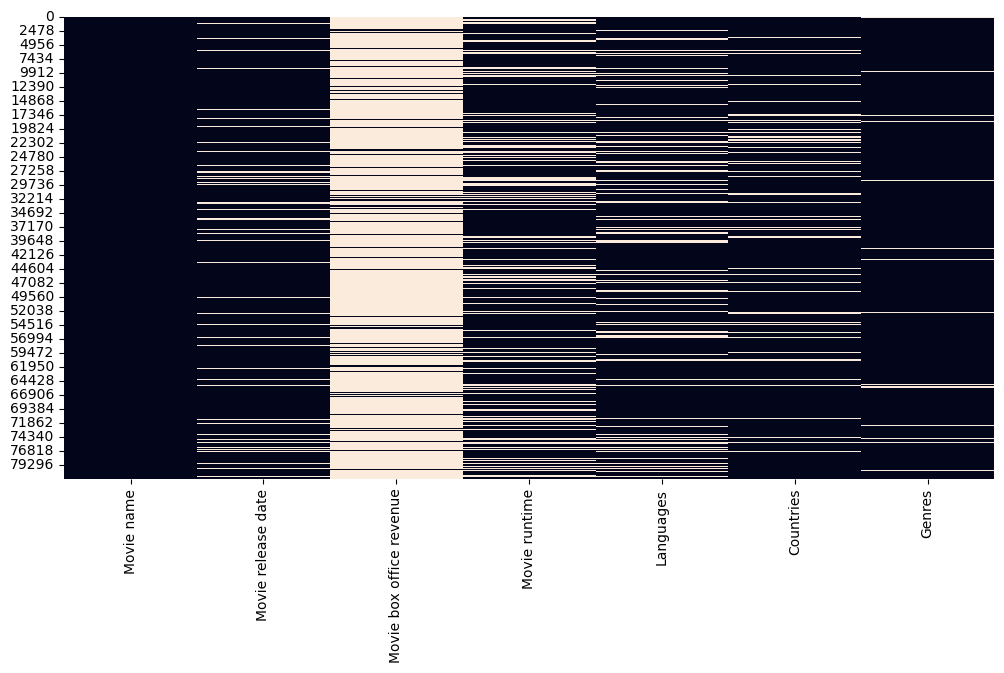

In [8]:
# Replace " " by NaN
clean_movies_data=raw_movies_data.copy()
clean_movies_data.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Plot for the missing values
plt.figure(figsize=(12, 6))
sns.heatmap(clean_movies_data.isnull(), cbar=False)
plt.show()

The columns 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Languages', 'Countries' and 'Genres' contain a number of missing values. Let's quantify them :

In [9]:
# Compute the percentage of missing values for each column
nb_missing_values = clean_movies_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (clean_movies_data.copy().isnull().mean() * 100).sort_values(ascending=False)

# Display in a dataframe
missing_values_df = pd.DataFrame({
    'Missing values': nb_missing_values,
    'Percentage (%)': missing_values_percentage
})
print(missing_values_df)

                          Missing values  Percentage (%)
Movie box office revenue           73340       89.722416
Movie runtime                      20450       25.018045
Languages                          13866       16.963335
Countries                           8154        9.975410
Movie release date                  6902        8.443743
Genres                              2294        2.806425
Movie name                             0        0.000000


Almost 90% of the movies are missing the information about the box office revenue, thus we cannot drop the rows with missing value in this column. However, our analysis focuses on movie genres so we need to drop the rows where the data for the movie genre is missing. 

By doing so, we loose around 2.8% of the data (2294 rows), which is reasonnable.

In [10]:
# The lines with nan values in genre and countries are removed
clean_movies_data= clean_movies_data.dropna(subset=["Genres"])
clean_movies_data= clean_movies_data.dropna(subset=["Countries"])
print("After removal of movies with missing genres, our dataset is", len(clean_movies_data), "movies long.")

After removal of movies with missing genres, our dataset is 71898 movies long.


Another fundamental variable for our project is the movie release date. Movies with missing dates are unusable and must therefore be removed from the dataset. This corresponds to another 6370 movies.

In [11]:
clean_movies_data = clean_movies_data.dropna(subset=["Movie release date"])
print("We are now left with", len(clean_movies_data), "movies.")

We are now left with 68144 movies.


### Data formatting

We also observe that the movie release dates are in different formats, so we need to format the data. For our analysis, we will only need the year.

In [12]:
clean_movies_data['Year'] = clean_movies_data['Movie release date'].apply(extract_year)
clean_movies_data.drop(columns=["Movie release date"], inplace=True)
clean_movies_data.head(3)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,Brun bitter,NaN,83.0,Norwegian,Norway,"Crime Fiction, Drama",1988


In [13]:
print("This is the lenght before using extract_year function:", len(clean_movies_data))
clean_movies_data= clean_movies_data.dropna(subset=["Year"])
print("This is the lenght after using extract_year function:", len(clean_movies_data))

This is the lenght before using extract_year function: 68144
This is the lenght after using extract_year function: 68143


The function extract_year failed to transform one date. The corresponding row is thus removed from the dataset.

### Save the dataset

The dataset has been cleaned and reformatted for easier analysis, and we’ve saved the updated version.

In [14]:
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'

# Save the reformatted dataset
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [15]:
preprocessed_movies = pd.read_csv(processed_data_path)
print("After the preprocessing steps, the dataframe has", len(preprocessed_movies), "rows.")

removed_lines = initial_length - len(preprocessed_movies)
removed_percentage = (removed_lines / initial_length) * 100

print("A total of " f"{removed_lines} rows were removed during the cleaning process which corresponds to {removed_percentage:.1f}% of the initial dataset.")

After the preprocessing steps, the dataframe has 68143 rows.
A total of 13598 rows were removed during the cleaning process which corresponds to 16.6% of the initial dataset.


In [16]:
preprocessed_movies.head(3)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000
2,Brun bitter,NaN,83.0,Norwegian,Norway,"Crime Fiction, Drama",1988


After handling the missing values and forlating the data, we are left with 68143 movies in our data set from the initial 81741. We removed 16.6% of the rows.

This is not too large and we still retain a good amount of information to work with, all while ensuring that our analysis will stay pertinent.



## 3 - Univariate Analysis

Now that we've looked at missing values, it is time to assess one by one the different variables from our data independently to understand its characteristics, look for outliers and trends in their distribution. 

### Movie Runtime

In [17]:
preprocessed_movies['Movie runtime'].describe()

count    5.572300e+04
mean     1.135852e+02
std      4.572194e+03
min      0.000000e+00
25%      8.200000e+01
50%      9.300000e+01
75%      1.070000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

Let's get rid of these outliers!

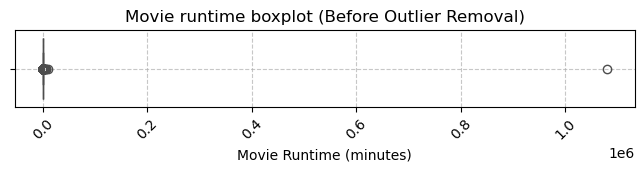

There are 3737 outliers among the 55723 runtime values which corresponds to 6.71% of the values.


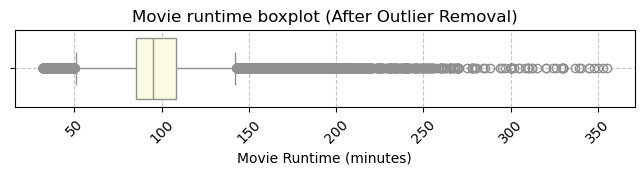

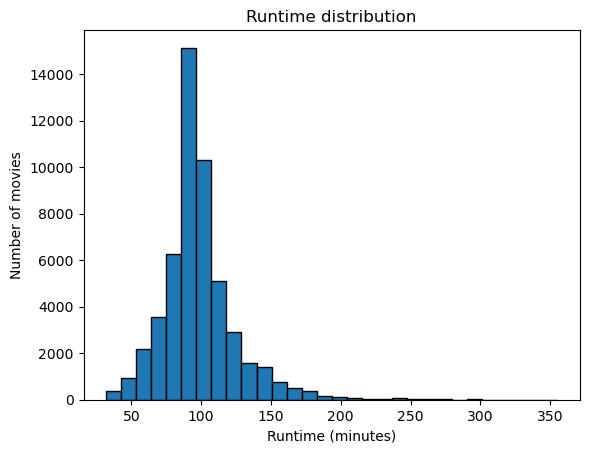

count    51986.000000
mean        98.596123
std         26.921654
min         32.000000
25%         85.000000
50%         95.000000
75%        108.000000
max        355.000000
Name: Movie runtime, dtype: float64

In [18]:
runtime_data = preprocessed_movies['Movie runtime'].dropna()


# Boxplot before outlier removal
plt.figure(figsize=(8, 1))

sns.boxplot(runtime_data, color='yellow', orient='h')
plt.title('Movie runtime boxplot (Before Outlier Removal)')
plt.xlabel('Movie Runtime (minutes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#Identification and removing of outliers 
low_factor=2
up_factor = 10 #We choose a large factor because the distribution is right-skewed and we want to make sure that we do not exclude values that are not outliers.
lower_bound, upper_bound=outliers_bounds(runtime_data, low_factor, up_factor)
outliers = runtime_data[(runtime_data < lower_bound) | (runtime_data > upper_bound)]
print(f"There are {len(outliers)} outliers among the {len(runtime_data)} runtime values which corresponds to {len(outliers)/len(runtime_data)*100:.2f}% of the values.")

no_outlier_data=preprocessed_movies.copy()
no_outlier_data = no_outlier_data[(no_outlier_data['Movie runtime'] >= lower_bound) & (no_outlier_data['Movie runtime'] <= upper_bound)]


plt.figure(figsize=(8, 1))

sns.boxplot(no_outlier_data['Movie runtime'], color='lightyellow', orient='h')
plt.title('Movie runtime boxplot (After Outlier Removal)')
plt.xlabel('Movie Runtime (minutes)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


#Runtime distribution
plt.figure()
plt.hist(no_outlier_data['Movie runtime'], bins=30, edgecolor='black')
plt.title('Runtime distribution')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of movies')
plt.show()

no_outlier_data['Movie runtime'].describe()

From the graphical (boxplot) and non-graphical (statistical) description of this variable, we are able to identify the presence of outliers. The maximum value (1 million minutes) is clearly aberrant. The other outliers can be defined using a certain threshold range and removed from the dataset. 

After cleaning, the distribution of movie runtime seems almost to follow a negative binomial distribution.

For now, this variable does not seem as most relevant to our study, but we may want to retain it for now.

### Movie Box Office Revenue

In [19]:
preprocessed_movies['Movie box office revenue'].describe()

count    8.225000e+03
mean     4.865907e+07
std      1.129534e+08
min      1.000000e+04
25%      2.153070e+06
50%      1.098933e+07
75%      4.162405e+07
max      2.782275e+09
Name: Movie box office revenue, dtype: float64

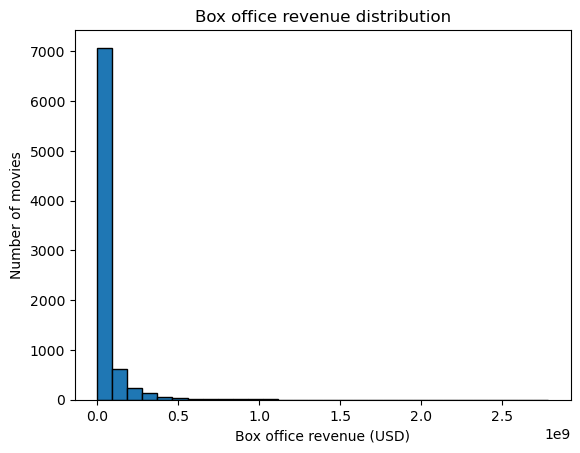

In [20]:
#Box office revenue distribution
plt.figure()
plt.hist(preprocessed_movies['Movie box office revenue'], bins=30, edgecolor='black')
plt.title('Box office revenue distribution')
plt.xlabel('Box office revenue (USD)')
plt.ylabel('Number of movies')
plt.show()

In [21]:
top_10_box_office = preprocessed_movies.sort_values(by='Movie box office revenue', ascending=False).head(10)
top_10_box_office

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
19734,Avatar,2.782275e+09,178.0,"English , Spanish","United States of America, United Kingdom","Thriller, Science Fiction, Adventure, Computer...",2009
18527,Titanic,2.185372e+09,194.0,"Italian , English , French , Swedish , Russian...",United States of America,"Tragedy, Costume drama, Historical fiction, Ac...",1997
23460,The Avengers,1.511758e+09,137.0,"Russian , English",United States of America,"Science Fiction, Action",2012
25218,Harry Potter and the Deathly Hallows – Part 2,1.328111e+09,130.0,English,"United States of America, United Kingdom","Drama, Mystery, Fantasy, Adventure",2011
15493,Transformers: Dark of the Moon,1.123747e+09,157.0,English,United States of America,"Alien Film, Science Fiction, Action, Adventure",2011
67463,The Lord of the Rings: The Return of the King,1.119930e+09,250.0,"Old English language, English","United States of America, New Zealand","Fantasy Adventure, Adventure, Epic, Action/Adv...",2003
45641,The Dark Knight Rises,1.078009e+09,165.0,English,"United States of America, United Kingdom","Crime Fiction, Thriller, Action, Drama",2012
58020,Toy Story 3,1.063172e+09,102.0,"English , Spanish",United States of America,"Adventure, Children's/Family, Computer Animati...",2010
11871,Pirates of the Caribbean: On Stranger Tides,1.043872e+09,136.0,English,United States of America,"Swashbuckler films, Adventure, Costume Adventu...",2011
41711,Star Wars Episode I: The Phantom Menace,1.027045e+09,136.0,English,United States of America,"Science Fiction, Action, Fantasy, Adventure, F...",1999


There do not seem to be any significant outliers in this variable, which is reassuring because we are already quite limited in terms of the number of instances due to the high number of missing values in this category.

Once more, the distribution is resemblant to a negative binomial one, but mostly most values remain around e+07, with very few great box office hits above 0.5e+09. We may want to keep this variable for our study as it may be an intresting criteria to assess a movie success and influence. We must however note that from the initial analysis and cleaning, a lot of values were missing. This could explain the greatly unbalanced distribution described in the histogram and must be considered as a influential factor as we continue this study.

### Movie Release Year

Movie release years is one of the most important numerical value of our analysis. We must therefore carefully study its distribution and trends.

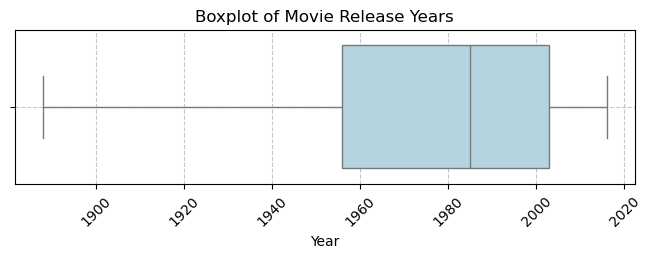

In [22]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=preprocessed_movies['Year'].astype(int), color='lightblue')
plt.title('Boxplot of Movie Release Years')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

It is important to note for our future analysis that the number of movies produced each year is not uniform. This variability should be taken into account when comparing film counts over time. In some cases, using proportions instead of absolute numbers might provide more meaningful insights.

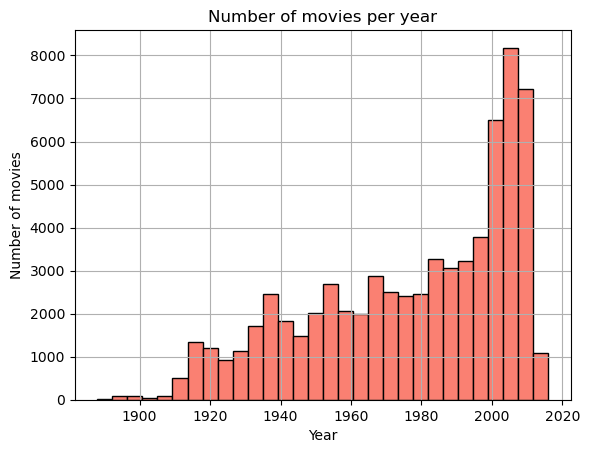

In [23]:
preprocessed_movies["Year"].hist(bins=30, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color='salmon', edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.title("Number of movies per year")
plt.show()

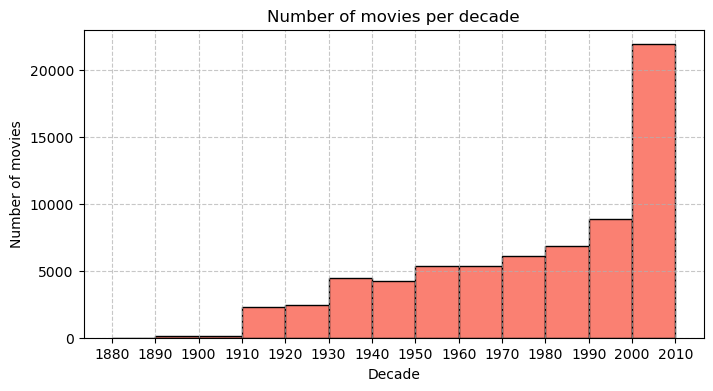

In [24]:
#Compute decade to which each movie corresponds
decades=(preprocessed_movies['Year'] // 10) * 10

plt.figure(figsize=(8, 4))
decades.hist(bins=range(decades.min(), decades.max() + 10, 10), color='salmon', edgecolor='black')
plt.xlabel("Decade")
plt.ylabel("Number of movies")
plt.xticks(range(decades.min(), decades.max() + 10, 10))
plt.title("Number of movies per decade")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Movie Genres

In this section, we examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [25]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")
print("-"*32) 
print(f"\nList of all the genre: \n{genres}")
print("-"*32) 

There are 362 genres in the dataset
--------------------------------

List of all the genre: 
['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom 

Movies are classified into various genres that capture themes, styles, or settings. However, not all these aspects are relevant to our analysis, so we need to select genres that allow us to group films meaningfully.

Let's begin by  focusing on the number of movies in each genre category.

#### > Number of movie per genre

In [26]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()
genres_counts

Genres
Drama              30521
Comedy             15419
Romance Film        9354
Black-and-white     8761
Thriller            8110
                   ...  
C-Movie                1
Comdedy                1
War effort             1
Breakdance             1
Homoeroticism          1
Name: count, Length: 362, dtype: int64

In [27]:
#Genres assigned to 10 movies or less
rare_genres = genres_counts[genres_counts <= 10]
rare_genres_counts = len(rare_genres)

print(f"Number of genres assigned to 10 movies or less  : {rare_genres_counts}")

Number of genres assigned to 10 movies or less  : 86


A lot of genres might not be meaningful because they contain few movies. In particular, 87 genres are assigned to 10 movies or less.

In order to keep only relevant genres, we can define an arbitrary threshold for the number of movies assigned to each genre.

In [28]:
#Threshold
threshold = 50
# Garder uniquement les genres assignés à plus de 50 films
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than  movies {threshold}: {len(relevant_genres)}")

Number of genres assigned to more than  movies 50: 196


Now we look at the distribution of the most widespread genres.

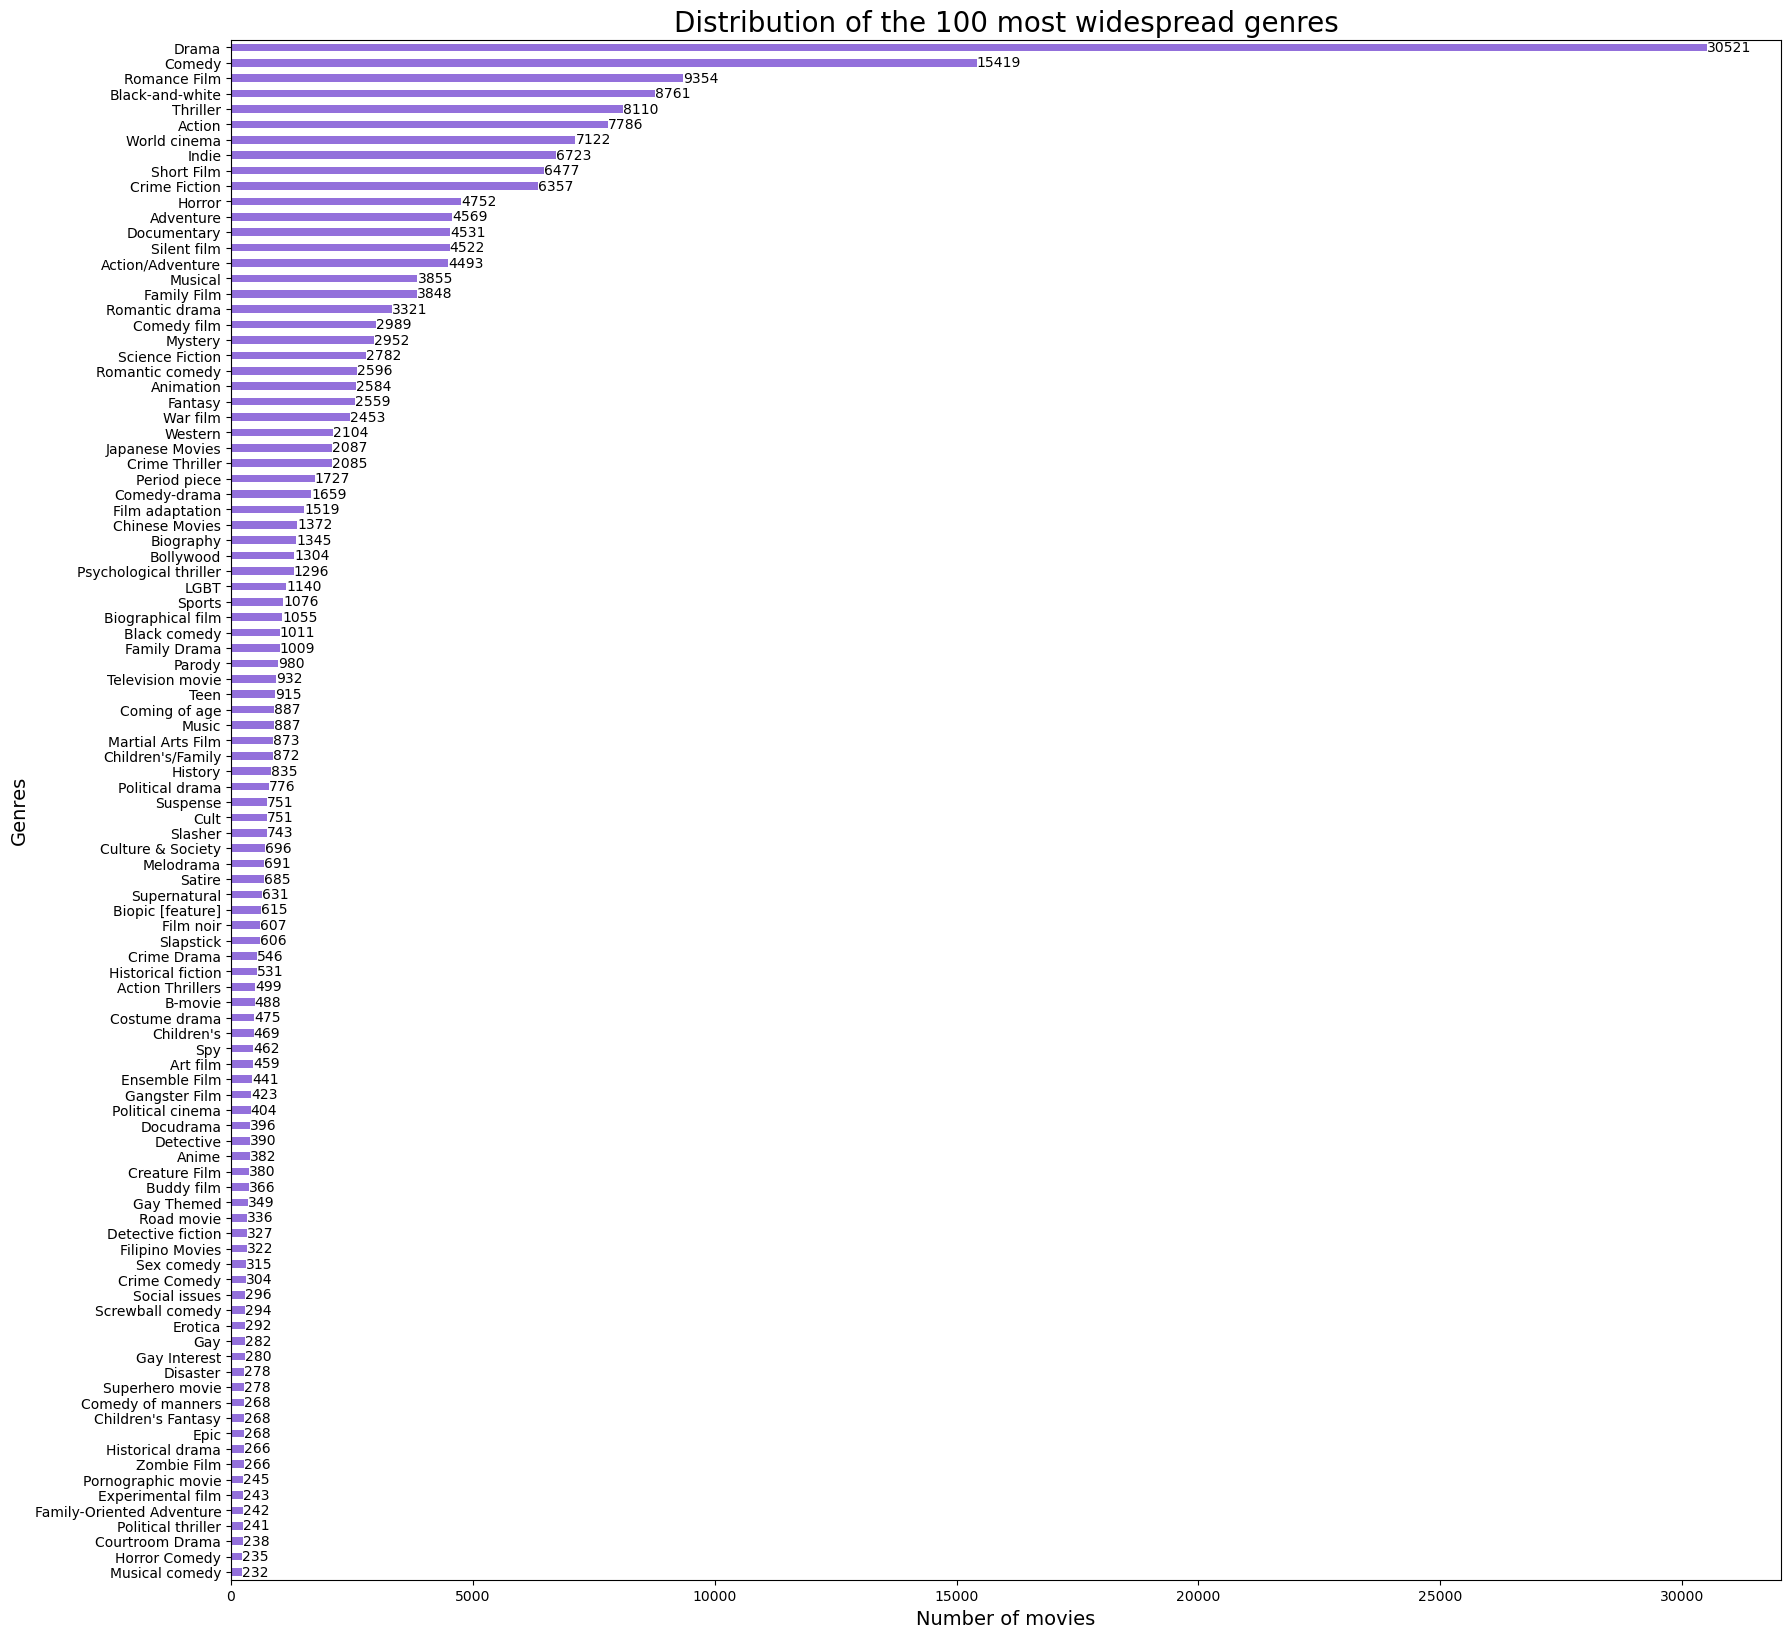

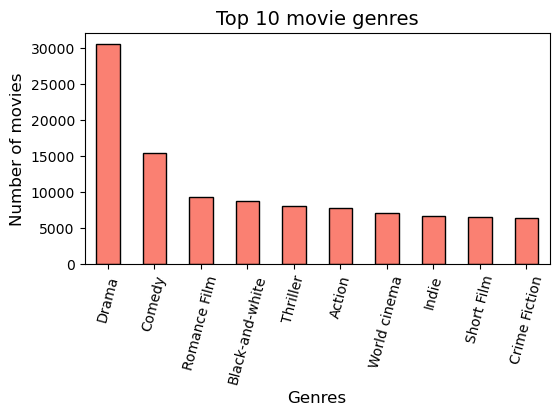

In [29]:
#100 most widespread genres
top_100_genres = relevant_genres.head(100)

plt.figure(figsize=(20, 20))
top_100_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=14)
plt.ylabel('Genres', fontsize=14)
plt.title('Distribution of the 100 most widespread genres', fontsize=20)
plt.gca().invert_yaxis() 

for index, value in enumerate(top_100_genres):
    plt.text(value, index, str(value), va='center')
    
plt.show()

#10 most widespread genres
top_10_genres = relevant_genres.iloc[:10]

top_10_genres.plot(kind='bar', x='Genres', y='Count', color='salmon', edgecolor='black', figsize=(6, 3))
plt.xlabel('Genres', fontsize=12)
plt.xticks(rotation=75)
plt.ylabel('Number of movies', fontsize=12)
plt.title('Top 10 movie genres', fontsize=14)
plt.show()

We observe that the 4th genre is "Black and White" and the 7th is "Short Film"—both of which are not relevant to our analysis. We can manually remove these and other unhelpful categories to focus on more meaningful genre information.

In [30]:
#remove all the genre that give information about the technical aspect of the movie rather than the content
technical_information = ['Silent film','Short Film','Musical', 'Film adaptation',"Black-and-white", "Music", "Teen", "Stop Motion"]
country_information = ["Indie","Japanese Movies", "Chinese Movies", "Bollywood"]
unwanted_genres = technical_information + country_information

preprocessed_movies['Genres'] = preprocessed_movies['Genres'].apply(lambda x: filter_genres(x, unwanted_genres=unwanted_genres))

#### > Balancing Genre Reduction with Dataset Coveragee

Even if we want to choose a reduced set of genres, we still want to retain a significant portion of the dataset.
We will try to identify the minimum number of genres needed to cover the majority of films in our dataset.
Specifically, we want to analyze how many films fall into groups defined by an increasing number of genres and determine how many genres are required to capture, for example, 90% of all films.

In [31]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']
genre_counts.head(10)

,Genres,Count
0,Drama,30521
1,Comedy,15419
2,Romance Film,9354
3,Thriller,8110
4,Action,7786
5,World cinema,7122
6,Crime Fiction,6357
7,Horror,4752
8,Adventure,4569
9,Documentary,4531


In [32]:
genre_counts_top_100 = genre_counts.iloc[:100]
genre_counts_top_30 = genre_counts.iloc[:30]
genre_counts_top_10 = genre_counts.iloc[:10]
genre_counts_top_3 = genre_counts.iloc[:3]

In [33]:
# Define a list of genre counts for each top N genres
genre_counts_list = [genre_counts_top_100, genre_counts_top_30, genre_counts_top_10, genre_counts_top_3]
top_n_values = [100, 30, 10, 3]

coverages = {}
for top_n, genre_counts in zip(top_n_values, genre_counts_list):
    _, coverage = most_common_genres(preprocessed_movies, genre_counts, top_n)
    coverages[top_n] = coverage

for top_n, coverage in coverages.items():
    print(f"Number of films covered by the {top_n} major genres: {coverage:.2f}%")

print("-"*32)
print(f"60% of the film are classified into the third major genres that are \n" , genre_counts_top_3['Genres'].values,  f"\n\nUp to 91% of the film are classified into the 30 major genres that are: \n", genre_counts_top_10['Genres'].values)
print("-"*32)

Number of films covered by the 100 major genres: 94.18%
Number of films covered by the 30 major genres: 92.59%
Number of films covered by the 10 major genres: 84.98%
Number of films covered by the 3 major genres: 63.41%
--------------------------------
60% of the film are classified into the third major genres that are 
 ['Drama' 'Comedy' 'Romance Film'] 

Up to 91% of the film are classified into the 30 major genres that are: 
 ['Drama' 'Comedy' 'Romance Film' 'Thriller' 'Action' 'World cinema'
 'Crime Fiction' 'Horror' 'Adventure' 'Documentary']
--------------------------------


Thus by a few genre we can cover a large part of the movies, but the remaining 9% of movies that are not covered by these major genres exhibit high variance, as they require many different genres to be classified

#### > Correlation Between Genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

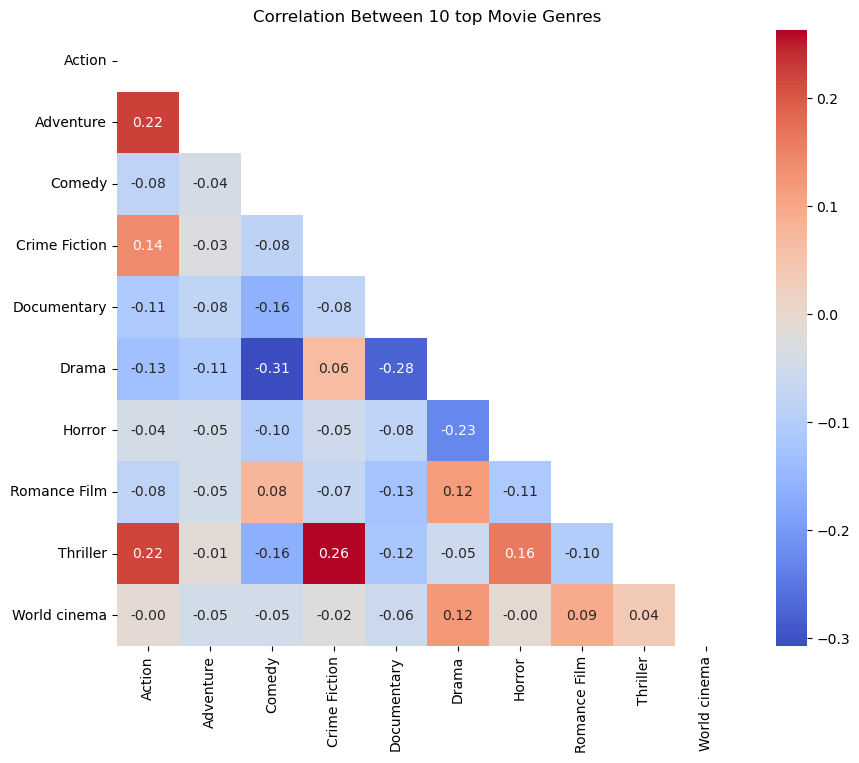

In [34]:
most_10commongenres,coverage10 = most_common_genres(preprocessed_movies, genre_counts_top_10, 10)
most_10commongenres = most_10commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_10commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_10commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

This heatmap illustrates how frequently two genres are used together to describe the same movie.
For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.
On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

Let's try this heat map for the top 30 genres now.

Index(['Action', 'Action/Adventure', 'Adventure', 'Animation',
       'Biographical film', 'Biography', 'Comedy', 'Comedy film',
       'Comedy-drama', 'Crime Fiction', 'Crime Thriller', 'Documentary',
       'Drama', 'Family Film', 'Fantasy', 'Horror', 'LGBT', 'Mystery',
       'Period piece', 'Psychological thriller', 'Romance Film',
       'Romantic comedy', 'Romantic drama', 'Science Fiction', 'Sports',
       'Thriller', 'War film', 'Western', 'World cinema'],
      dtype='object')


Text(0.5, 1.0, 'Correlation Between 10 top Movie Genres')

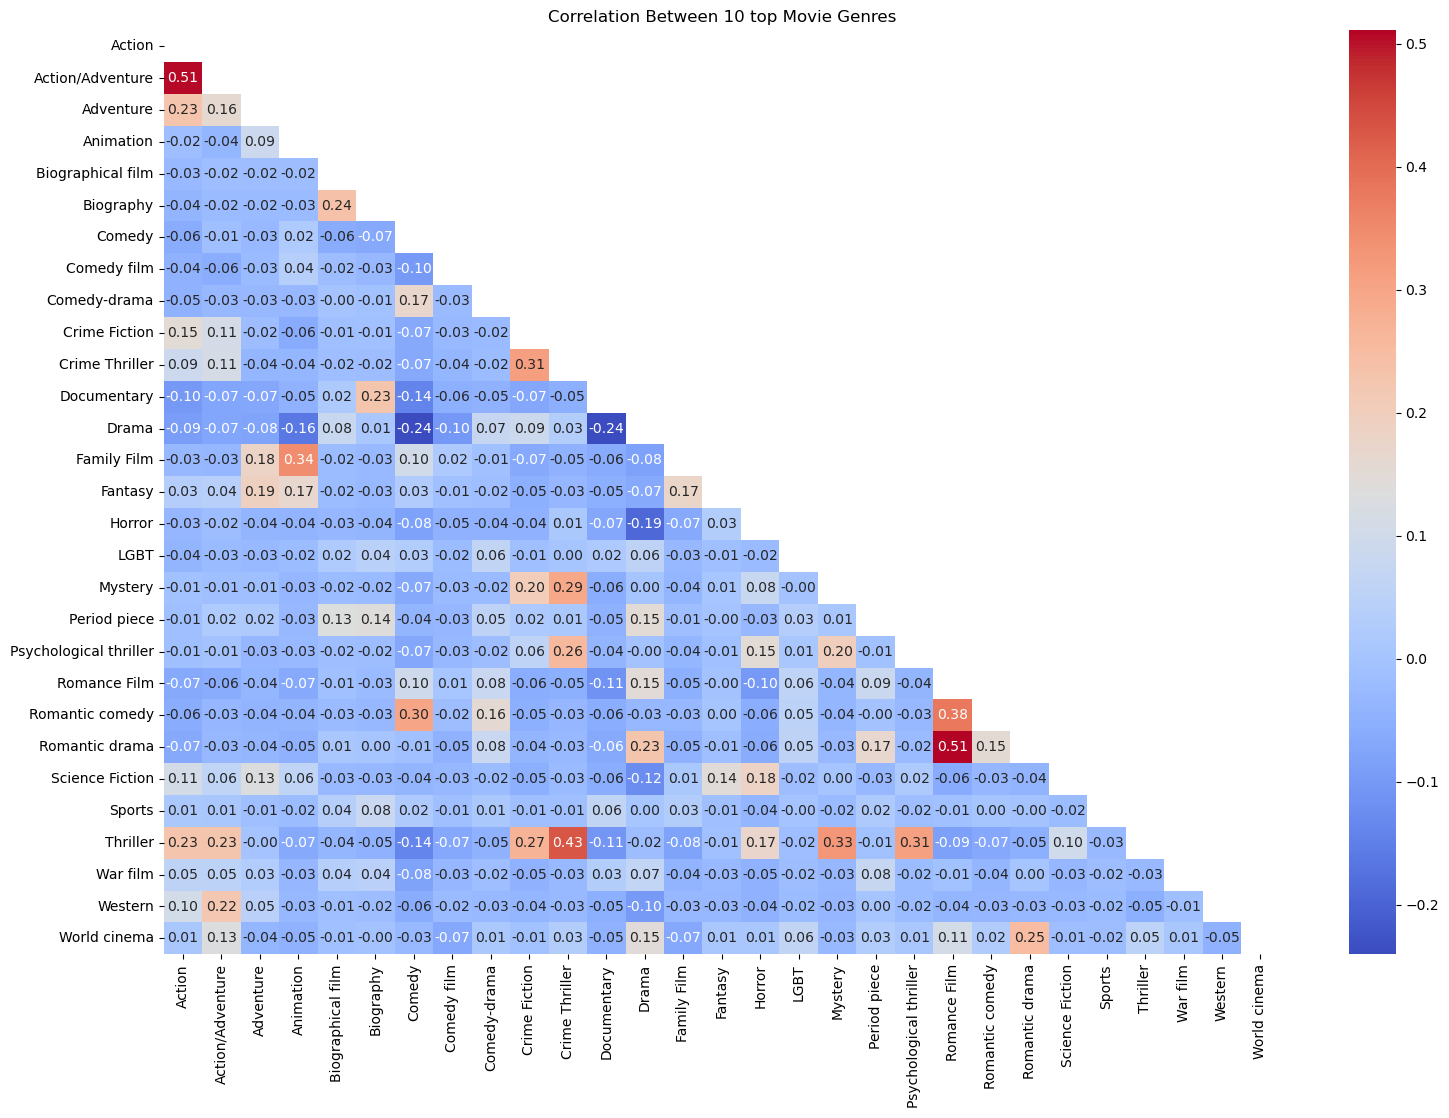

In [35]:
most_30commongenres,coverage30 = most_common_genres(preprocessed_movies, genre_counts_top_30, 30)
most_30commongenres = most_30commongenres.dropna(subset=['Genres'])

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_30commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_30commongenres.index)
genre_correlation = genre_binary_matrix.corr()

print(genre_correlation.index)

plt.figure(figsize=(18, 12))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')

Here, we observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

## 4 - Bivariate Analysis

### > Movie Genres over Time

We begin to analyze the distribution of different genres over times to look at correlations and trend between the variables Movie Release Date and Genre. For now, we focus our study on the ten most common genres.

In [36]:
# Select the top 10 genres
selected_genres = genre_counts_top_10['Genres'].values
genre_year_df = preprocessed_movies[['Year', 'Genres']].copy()

# Explode the genres into separate rows
genre_year_df = genre_year_df.assign(Movie_genres=genre_year_df['Genres'].str.split(', ')).explode('Genres')
genre_year_df = genre_year_df[genre_year_df['Genres'].isin(selected_genres)]

# Count the number of movies per genre per year
genre_year_counts = genre_year_df.groupby(['Year', 'Genres']).size().unstack(fill_value=0)

In [37]:
selected_genres

array(['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action',
       'World cinema', 'Crime Fiction', 'Horror', 'Adventure',
       'Documentary'], dtype=object)

In [38]:
genre_year_counts.columns  

Index(['Action', 'Adventure', 'Comedy', 'Crime Fiction', 'Documentary',
       'Drama', 'Horror', 'Romance Film', 'Thriller', 'World cinema'],
      dtype='object', name='Genres')

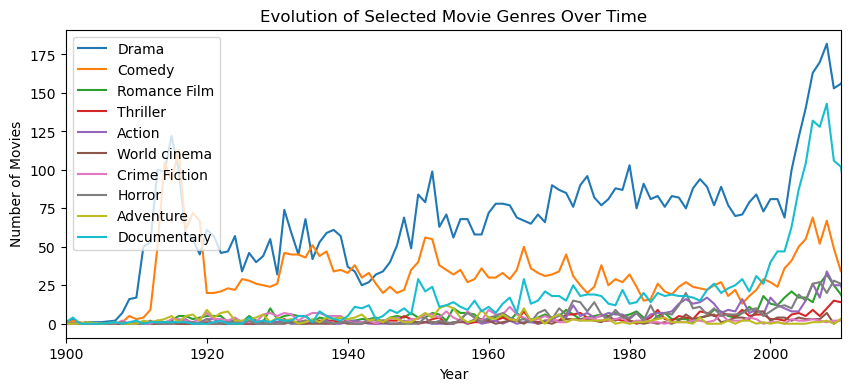

In [39]:
# Plot the evolution over time for each genre
plt.figure(figsize=(10, 4))
for genre in selected_genres:
    plt.plot(genre_year_counts.index, genre_year_counts[genre], label=genre)

# Set the range for the x-axis
plt.xlim(1900, 2010)

plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.title('Evolution of Selected Movie Genres Over Time')
plt.legend()
plt.show()

The graph reveals significant variations in the popularity of movie genres over time. We will later examine whether these fluctuations correlate with historical events or crises.

### > Movies per countries

In our analysis, we aim to examine the impact of historical events on the film industry across different countries. To begin, let’s look at the number of movies produced by each country in our dataset.

Since movies can be associated with more than one country, we will split the dataset so that each country listed for a movie is counted individually. This way, a movie will be included once for each country it’s attributed to.

In [40]:
movies_per_country_counts = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')
movies_per_country_counts = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')
movies_per_country_counts = movies_per_country_counts['Countries'].value_counts().reset_index()
movies_per_country_counts.columns = ['Countries', 'Movie_Count']


# Load a geopandas dataframe with the world map
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world_for_movie = gpd.read_file(shapefile_path)
world_for_movie = world_for_movie.rename(columns={'NAME': 'Countries'})

# Merged the geopandas dataframe with the movie count dataframe to display the number of movies per country on the world map                                        
merged = world_for_movie.merge(movies_per_country_counts, on='Countries', how='left')

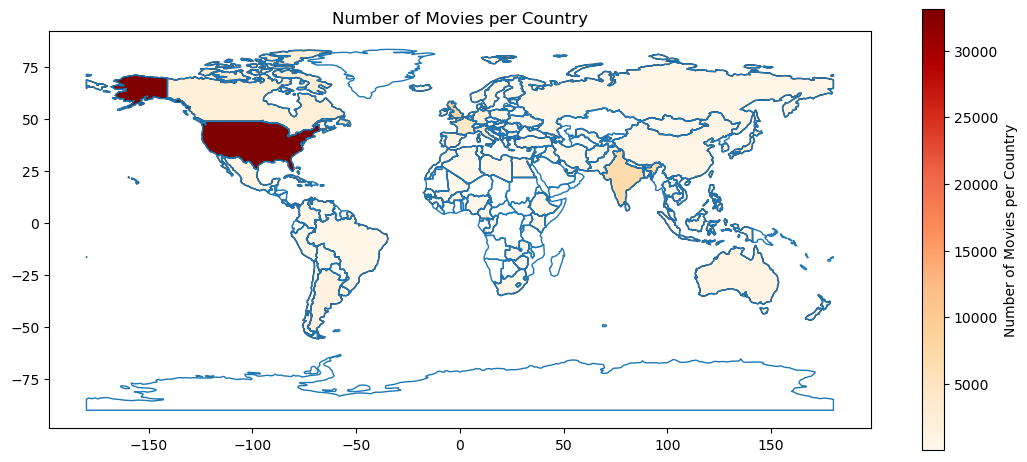

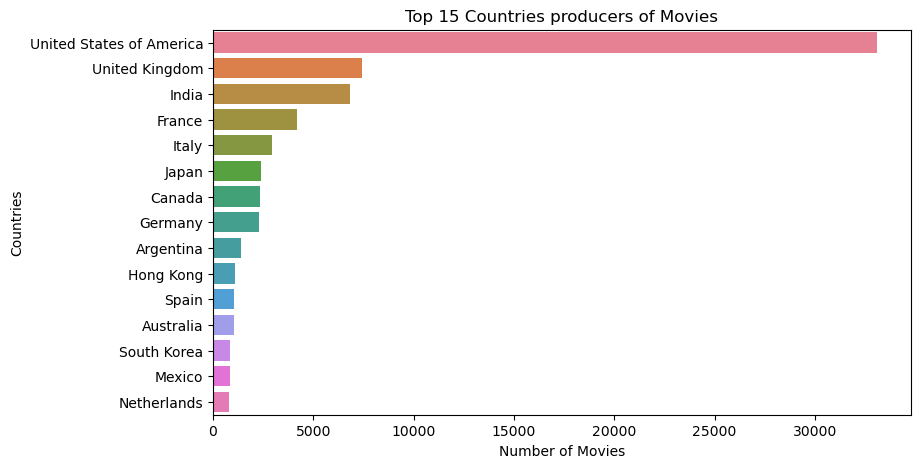

,Countries,Movie_Count
0,United States of America,33112
1,United Kingdom,7426


In [41]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))

fig.tight_layout()
world_for_movie.boundary.plot(ax=ax, linewidth=1)


legend_kwds={'label': "Number of Movies per Country",
             'orientation': "vertical"}

merged.plot(column='Movie_Count', ax=ax, legend=True,
            legend_kwds=legend_kwds,
            cmap='OrRd', edgecolor='black')

plt.title("Number of Movies per Country")
plt.show()

top15_contry_movie_production = movies_per_country_counts.iloc[:15]

plt.figure(figsize=(9, 5))
sns.barplot(x='Movie_Count', y='Countries', data=top15_contry_movie_production, hue='Countries', legend=False)
plt.ylabel('Countries')
plt.xlabel('Number of Movies')
plt.title('Top 15 Countries producers of Movies')
plt.show()

top15_contry_movie_production.head(2)

The United States has clearly dominated the film industry, with a total of 33,112 movies released—four times more than the United Kingdom, the second-highest producer of films. Let’s explore whether this dominance has been consistent over time or if it reflects a more recent trend.

,Top 1 country producer,Top 2 country producer,Top 3 country producer
Decade,,,
1850,France,United States of America,United Kingdom
1900,United States of America,United Kingdom,Germany
1950,United States of America,India,United Kingdom
2000,United States of America,India,United Kingdom


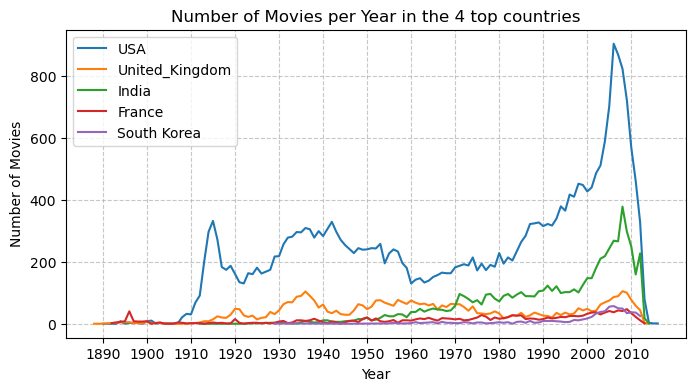

In [42]:
double_decades = (preprocessed_movies['Year'] // 50) * 50

best_country_per_decade = preprocessed_movies.assign(Countries=preprocessed_movies['Countries'].str.split(', ')).explode('Countries')

movies_per_decade_country = best_country_per_decade.groupby([double_decades, 'Countries']).size().unstack(fill_value=0)
top_3_countries_per_decade = movies_per_decade_country.apply(lambda x: x.nlargest(3).index.tolist(), axis=1)

# Create a DataFrame to display the top 10 countries per decade
top_3_countries_df = pd.DataFrame(top_3_countries_per_decade.tolist(), index=top_3_countries_per_decade.index)
top_3_countries_df.index.name = 'Decade'
top_3_countries_df.columns = [f'Top {i+1} country producer' for i in range(top_3_countries_df.shape[1])]

display(top_3_countries_df)

print("\n")

USA_movies = preprocessed_movies[preprocessed_movies['Countries']=='United States of America']
United_Kingdom_movies = preprocessed_movies[preprocessed_movies['Countries']=='United Kingdom']
France_movies = preprocessed_movies[preprocessed_movies['Countries']=='France']
India_movies = preprocessed_movies[preprocessed_movies['Countries']=='India'] 
South_Korea_movies = preprocessed_movies[preprocessed_movies['Countries']=='South Korea']

plt.figure(figsize=(8, 4))
plt.plot(USA_movies['Year'].value_counts().sort_index(), label='USA')
plt.plot(United_Kingdom_movies['Year'].value_counts().sort_index(), label='United_Kingdom')
plt.plot(India_movies['Year'].value_counts().sort_index(), label='India') 
plt.plot(France_movies['Year'].value_counts().sort_index(), label='France')
plt.plot(South_Korea_movies['Year'].value_counts().sort_index(), label='South Korea')

plt.title('Number of Movies per Year in the 4 top countries')
plt.xlabel('Year')
plt.xticks(range(preprocessed_movies['Year'].min()+2, preprocessed_movies['Year'].max(), 10))
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylabel('Number of Movies')
plt.legend()
plt.show()


We could see that the United States had always had an historical strong dominace on film industry since 1910. Hollywood has been a leading industry for many years and our data supports this. We do however see a rise in India for movie releases which could be due to growing importance of Bollywood and perhaps even suggesting a gradual exportation of indian movies abroad. This is something we can try to assess in our future analysis.  

### > Preliminary Study - War Movies

In this section, we’ll conduct a brief analysis of movies classified as "War Movies." This is a straightforward, focused genre analysis over time, where we’ll examine trends in war movie production, particularly to see if there was an increase in production around major wartime periods, such as the World Wars.

In [43]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]
print(len(War_movies), len(War_movies_comedy), len(War_movies_drama))

2467 225 1656


Text(0.5, 1.0, 'Number of movies per year')

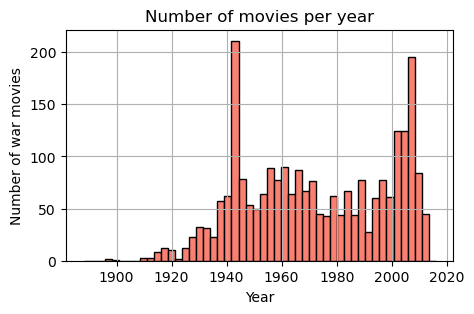

In [44]:
plt.figure(figsize=(5,3))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of movies per year")

The plot shows the number of war movies produced per year. There is a significant increase in war movie production during the 1940s, which aligns with World War II, suggesting that the conflict likely influenced the film industry. Another peak appears around the early 2000s.

We know that the repartition of the movie are right-screwed so let's look at the proportion instead of the number of movies.

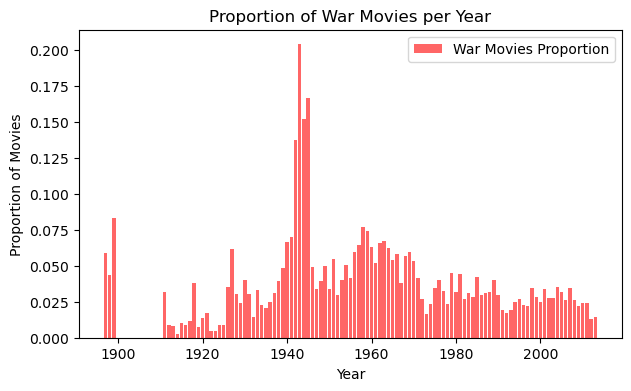

In [45]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()
war_movies_per_year = War_movies.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_movies_proportion = war_movies_per_year / total_movies_per_year

plt.figure(figsize=(7, 4))
plt.bar(war_movies_proportion.index, war_movies_proportion.values, label='War Movies Proportion', color='red', alpha=0.6)
plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('Proportion of War Movies per Year')
plt.legend(loc='upper right')
plt.show()

Another interesting question to explore is whether these war films tend to lean more toward comedic or dramatic themes.

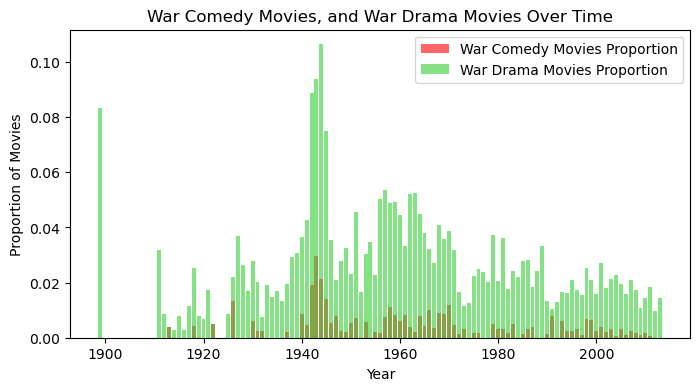

In [46]:
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

# Calculate the proportion of each category of movie per year
war_comedy_movies_proportion = war_comedy_movies_per_year / total_movies_per_year
war_drama_movies_proportion = war_drama_movies_per_year / total_movies_per_year

plt.figure(figsize=(8, 4))
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='red', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='limegreen', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('War Comedy Movies, and War Drama Movies Over Time')
plt.legend(loc='upper right')
plt.show()

The graph clearly shows that the theme of war is much more frequently portrayed from a dramatic rather than a comedic perspective.

Although our data seems to contain a good amount of information which we can utilize for our analysis, in order to incorporate historical events as a influencing variable for the distribution of our data and to understand the trends we observe from the modality of movie distribution, we need to import an additional dataset containing information about historical world events.

# Additional dataset : "World Important Events - Ancient to Modern"

We begin with the cleaning, preprocessing and investigation of this additional dataset, creating categories useful for analysis, such as "war," "economic crisis," and "period of stability." It could be intresting to vectorize and tokenize certain types of words by identifying the main categories that interest us.

We will begin with missing values as well as historical events that are too old for our analysis.
We also want to transform the date formats for temporal analysis to match the format of our movie dataset.

## 1 - Data Collection

We start with an overview of the historical dataset, an open-source collection titled "World Important Events - Ancient to Modern World."  (Author: Saket Kumar)

In [47]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.csv")
print(f"The initial dataframe has {len(raw_history_data)} lines.")

The initial dataframe has 1096 lines.


In [48]:
initial_length = len(raw_history_data)
raw_history_data.head(3)

,Sl. No,Name of Incident,Date,Month,Year,Country,Type of Event,Place Name,Impact,Affected Population,Important Person/Group Responsible,Outcome
0,1,Indus Valley Civilization Flourishes,Unknown,Unknown,2600 BC,India,Civilization,Indus Valley,Development of one of the world's earliest urb...,Local inhabitants,Indus Valley people,Positive
1,2,Battle of the Ten Kings,Unknown,Unknown,1400 BC,India,Battle,Punjab,Rigvedic tribes consolidated their control ove...,Rigvedic tribes,Sudas,Positive
2,6,Establishment of the Delhi Sultanate,Unknown,Unknown,1206,India,Political,Delhi,Muslim rule established in parts of India,People of Delhi and surrounding regions,QutbUnknownudUnknowndin Aibak,Mixed


## 2- Preliminary Data Cleaning

We can remove the columns "Place Name","Date" and "Month" of the dataset. We don't need such precision in the historical events date because our analysis will focus on their impact on film industry, and films are usually released years after. The Place Name is also a precision that we won't need, as we are working at the scale of countries.

In [49]:
# drop columns that we don't need.
cleaned_data_history = raw_history_data.copy()
cleaned_data_history.drop(columns=["Place Name","Date", "Month","Sl. No"], inplace=True)

In [50]:
# we can see that some of the dates are before Christ (BC). We can safely remove them, knowing that movies didn't exist at that time.
cleaned_data_history = cleaned_data_history[~cleaned_data_history['Year'].str.contains('BC')]

The historical dataset starts from very ancient times, we want to only keep events happening after the first movie was released. 

We also don't want the historical event that happens after the last movie that we got.

In [51]:
# for this purpose, we need to make the date values more convenient to work with, by converting the column ['Year'] from str to int
cleaned_data_history.loc[:, 'Year'] = cleaned_data_history.loc[:, 'Year'].astype(int)
    
# get the year of the first released movie
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
print('In our dataset, the first movie that was released was in', int(first_movie_year))
print('The last movie that was released was in', int(last_movie_year))
    
# remove historical events that happened before the first movie was released
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] >= first_movie_year]
cleaned_data_history = cleaned_data_history[cleaned_data_history['Year'] <= last_movie_year]
first_event_year = cleaned_data_history['Year'].min()
last_event_year = cleaned_data_history['Year'].max()

print('\n The first event in the historical dataset that happened after the first movie happened in', int(first_event_year))
print('The last event in the historical dataset that happened before the last movie happened in', int(last_event_year))

In our dataset, the first movie that was released was in 1888
The last movie that was released was in 2016

 The first event in the historical dataset that happened after the first movie happened in 1888
The last event in the historical dataset that happened before the last movie happened in 2016


To show on a world map the number of events happening in each country we will use a geopandas dataset. Some countries of the historical dataset have different names than geopandas, so we will need to format them to match. First of all, a primary analysis of these dfferences:

In [52]:
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
geopandas_countries = world['NAME'].unique()
events_countries = cleaned_data_history['Country'].unique()

# Elements in events_countries but not in geopandas_countries
differences = [item for item in events_countries if item not in geopandas_countries]
print(f"These countries from events_countries are not taken into account in geopandas map \n{differences}")

These countries from events_countries are not taken into account in geopandas map 
['UK', 'USSR', 'Korea', 'Singapore', 'Almaty', 'Bukhara', 'Malaya', 'Tehran', 'Samarkand', 'Maldives', 'Basra', 'Punakha', 'Soviet Union', 'Uzbek SSR', 'Addu Atoll', 'Kuwait, Iraq', 'Mosul', 'Zhanaozen', 'USA', 'Spain/USA', 'Congo (DRC)', 'Equatorial Guinea', 'Seychelles', 'Cape Verde', 'GuineaUnknownBissau', 'Comoros', 'Central African Republic', 'Congo (Brazzaville)', "Ivory Coast (Côte d'Ivoire)", 'Swaziland (Eswatini)', 'South Sudan']


Here are the steps to make these countries match:

In [53]:
#Replace USSR and Soviet Union by Russia as we are interested in the geographical location of the events
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USSR', 'Russia')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Soviet Union', 'Russia')

#replace name of countries to the appropriate format
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'USA', 'United States of America')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'UK', 'United Kingdom')
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Zhanaozen', 'Kazakhstan')

#Actually ! 'Tehran' is the capital of Iran
cleaned_data_history = replace_in_columns(cleaned_data_history, 'Country', 'Tehran', 'Iran')

# remove all the remaining rows of the dataset that contain a country that is not in the geopandas map
cleaned_data_history = cleaned_data_history[cleaned_data_history['Country'].isin(geopandas_countries)]

len(cleaned_data_history)

660

The dataset is reduced to 660, but that's fine because we don't need a very large dataset for the historical events. Instead we want to choose relevant ones to analyse their impact on film industry.

We also chose to remove columns with mixed outcome because these corresponding events would be too complex for analyzing their direct impact on film industry.

In [54]:
#Drop rows with "Mixed" in the outcome column
cleaned_data_history = cleaned_data_history[cleaned_data_history["Outcome"] != "Mixed"]
len(cleaned_data_history)

544

### Handling Missing values

C:\Users\lauri\AppData\Local\Temp\ipykernel_4760\2710673950.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cleaned_data_history.replace(r'^\s*$', np.nan, regex=True, inplace=True)


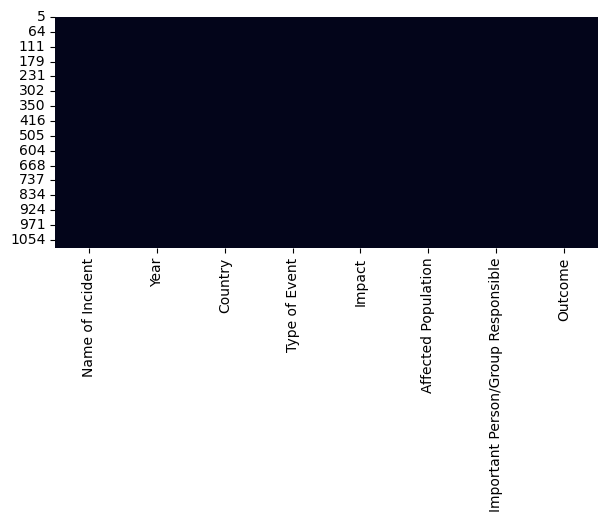

In [55]:
cleaned_data_history.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#Plot for the missing values
plt.figure(figsize=(7, 3))
sns.heatmap(cleaned_data_history.isnull(), cbar=False)
plt.show()

In [56]:
cleaned_data_history.info()

<class 'pandas.core.frame.DataFrame'>
Index: 544 entries, 5 to 1095
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Name of Incident                    544 non-null    object
 1   Year                                544 non-null    int64 
 2   Country                             544 non-null    object
 3   Type of Event                       544 non-null    object
 4   Impact                              544 non-null    object
 5   Affected Population                 544 non-null    object
 6   Important Person/Group Responsible  544 non-null    object
 7   Outcome                             544 non-null    object
dtypes: int64(1), object(7)
memory usage: 38.2+ KB


There are no missing values in the cleaned data history. 

### Saving to CSV file (je sais toujours pas ou le mettre)

In [57]:
# save the cleaned data to a csv file
processed_data_path = 'data/Preprocessed_data/preprocessed_history.csv'
cleaned_data_history.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [58]:
preprocessed_history = cleaned_data_history.copy()
preprocessed_history.head(2)

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
5,Partition of India,1947,India,Partition,Creation of India and Pakistan; massive popula...,"Hindus, Muslims, Sikhs","British Empire, Indian political leaders",Negative
6,IndoUnknownPakistani War of 1971,1971,India,War,Led to the independence of Bangladesh,Bengalis in East Pakistan,"Indian Military, Mukti Bahini",Negative


At the end, a new csv file containing the cleaned data was created, in the file preprocessed_history.csv

In [59]:
print("The dataframe following preprocessing steps has ", len(preprocessed_history), "lines.")
print(initial_length - len(preprocessed_history), "lines were lost following the cleaning steps.")

The dataframe following preprocessing steps has  544 lines.
552 lines were lost following the cleaning steps.


## 3 - Univariate analysis

Once more, we may assess one by one the different variables from our data independently to understand characteristics, look for outliers and trends in their distribution.
Let's visualize the  distribution of the number of events that happened each year in the historical dataset.

### > Event Year

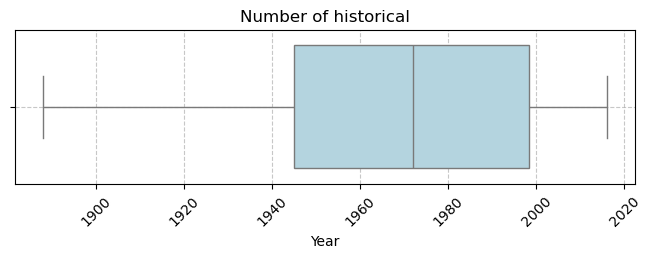

In [60]:
plt.figure(figsize=(8, 2))
sns.boxplot(x=preprocessed_history['Year'].astype(int), color='lightblue')
plt.title('Number of historical')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Historical events  each year')

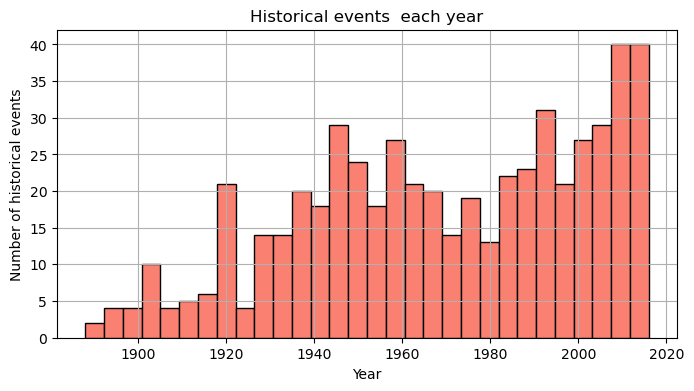

In [61]:
plt.figure(figsize=(8, 4))

preprocessed_history["Year"].hist(bins=30, range=(preprocessed_history["Year"].min(), preprocessed_history["Year"].max()), color = 'salmon', edgecolor = 'black') 
plt.xlabel("Year")
plt.ylabel("Number of historical events")
plt.title("Historical events  each year")  

In [62]:
top5 = preprocessed_history["Country"].value_counts().iloc[:5]
top5_countries = preprocessed_history[preprocessed_history["Country"].isin(top5.index[:5])]

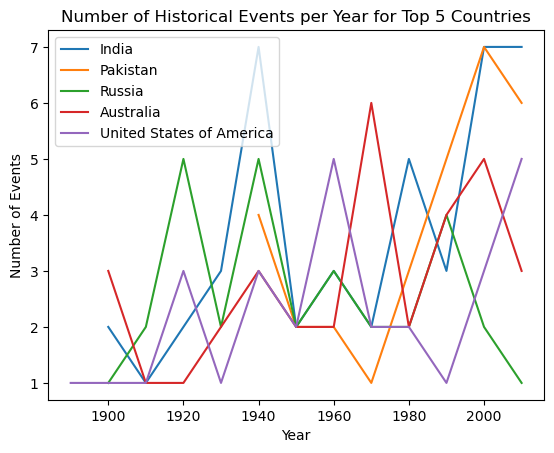

In [63]:
for country in top5_countries["Country"].unique():
    country_data = top5_countries[top5_countries["Country"] == country].copy()
    country_data['Decade'] = (country_data['Year'] // 10) * 10
    yearly_counts = country_data.groupby('Decade').size()
    plt.plot(yearly_counts.index, yearly_counts.values, '-', label=country)

plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Number of Historical Events per Year for Top 5 Countries')
plt.legend()
plt.show()

# PIRE GRAPH DU MONDE je vais essayer d ameliorer ca au plus vite + peut etre faire un commentaire dessus?

### > Event Type

In [64]:
#Number of event types in the dataset
t_events = preprocessed_history['Type of Event'].str.split(', ').explode().unique()
print(len(t_events),t_events)

229 ['Partition' 'War' 'Terrorism' 'National Movement'
 'Agricultural Revolution' 'Military Operation' 'Military Conflict'
 'Legislation' 'Criminal Incident' 'Political' 'Industrial Disaster'
 'Economic Policy' 'Infrastructure' 'Sports' 'Natural Disaster'
 'Space Exploration' 'Financial Technology' 'Telecommunications'
 'Environmental/Social' 'International Cooperation' 'Administrative'
 'Massacre' 'Civil Disobedience Movement' 'Violent Protest'
 'Civil Disobedience' 'Political Declaration' 'Mass Protest' 'Negotiation'
 'Famine' 'Political Decision' 'Political Integration'
 'Constitutional Adoption' 'Central Banking Institution' 'Space Agency'
 'Political Party' 'Regulatory Body' 'Country Formation'
 'International Relations' 'Constitutional' 'Economic/Infrastructure'
 'Monument' 'International Agreement' 'Scientific Organization'
 'International Recognition' 'Social Welfare Program'
 'Constitutional Amendment' 'Government Agency' 'Nuclear Energy'
 'Education' 'Security Policy' 'Ethnic

There are 310 different event types in the historical data. Just as we did for the genres in the movies, we can attempt to select a more relevant subset of these types. For this preliminary analysis, we can select a subset of these events (Wars for example? - maybe regroup war dates, see if there is a period with many wars which correlates with movies about war?)

Let's count the number of dates in each event type.

In [65]:
e_types_counts = preprocessed_history['Type of Event'].str.split(', ').explode().value_counts()
e_types_counts

Type of Event
Political                 46
Independence              34
Military Conflict         18
Military                  18
Economic                  12
                          ..
Political/Legal            1
Constitutional/Legal       1
Legal/Constitutional       1
Humanitarian/Political     1
Religious                  1
Name: count, Length: 229, dtype: int64

Looking at the distribution of types of events:

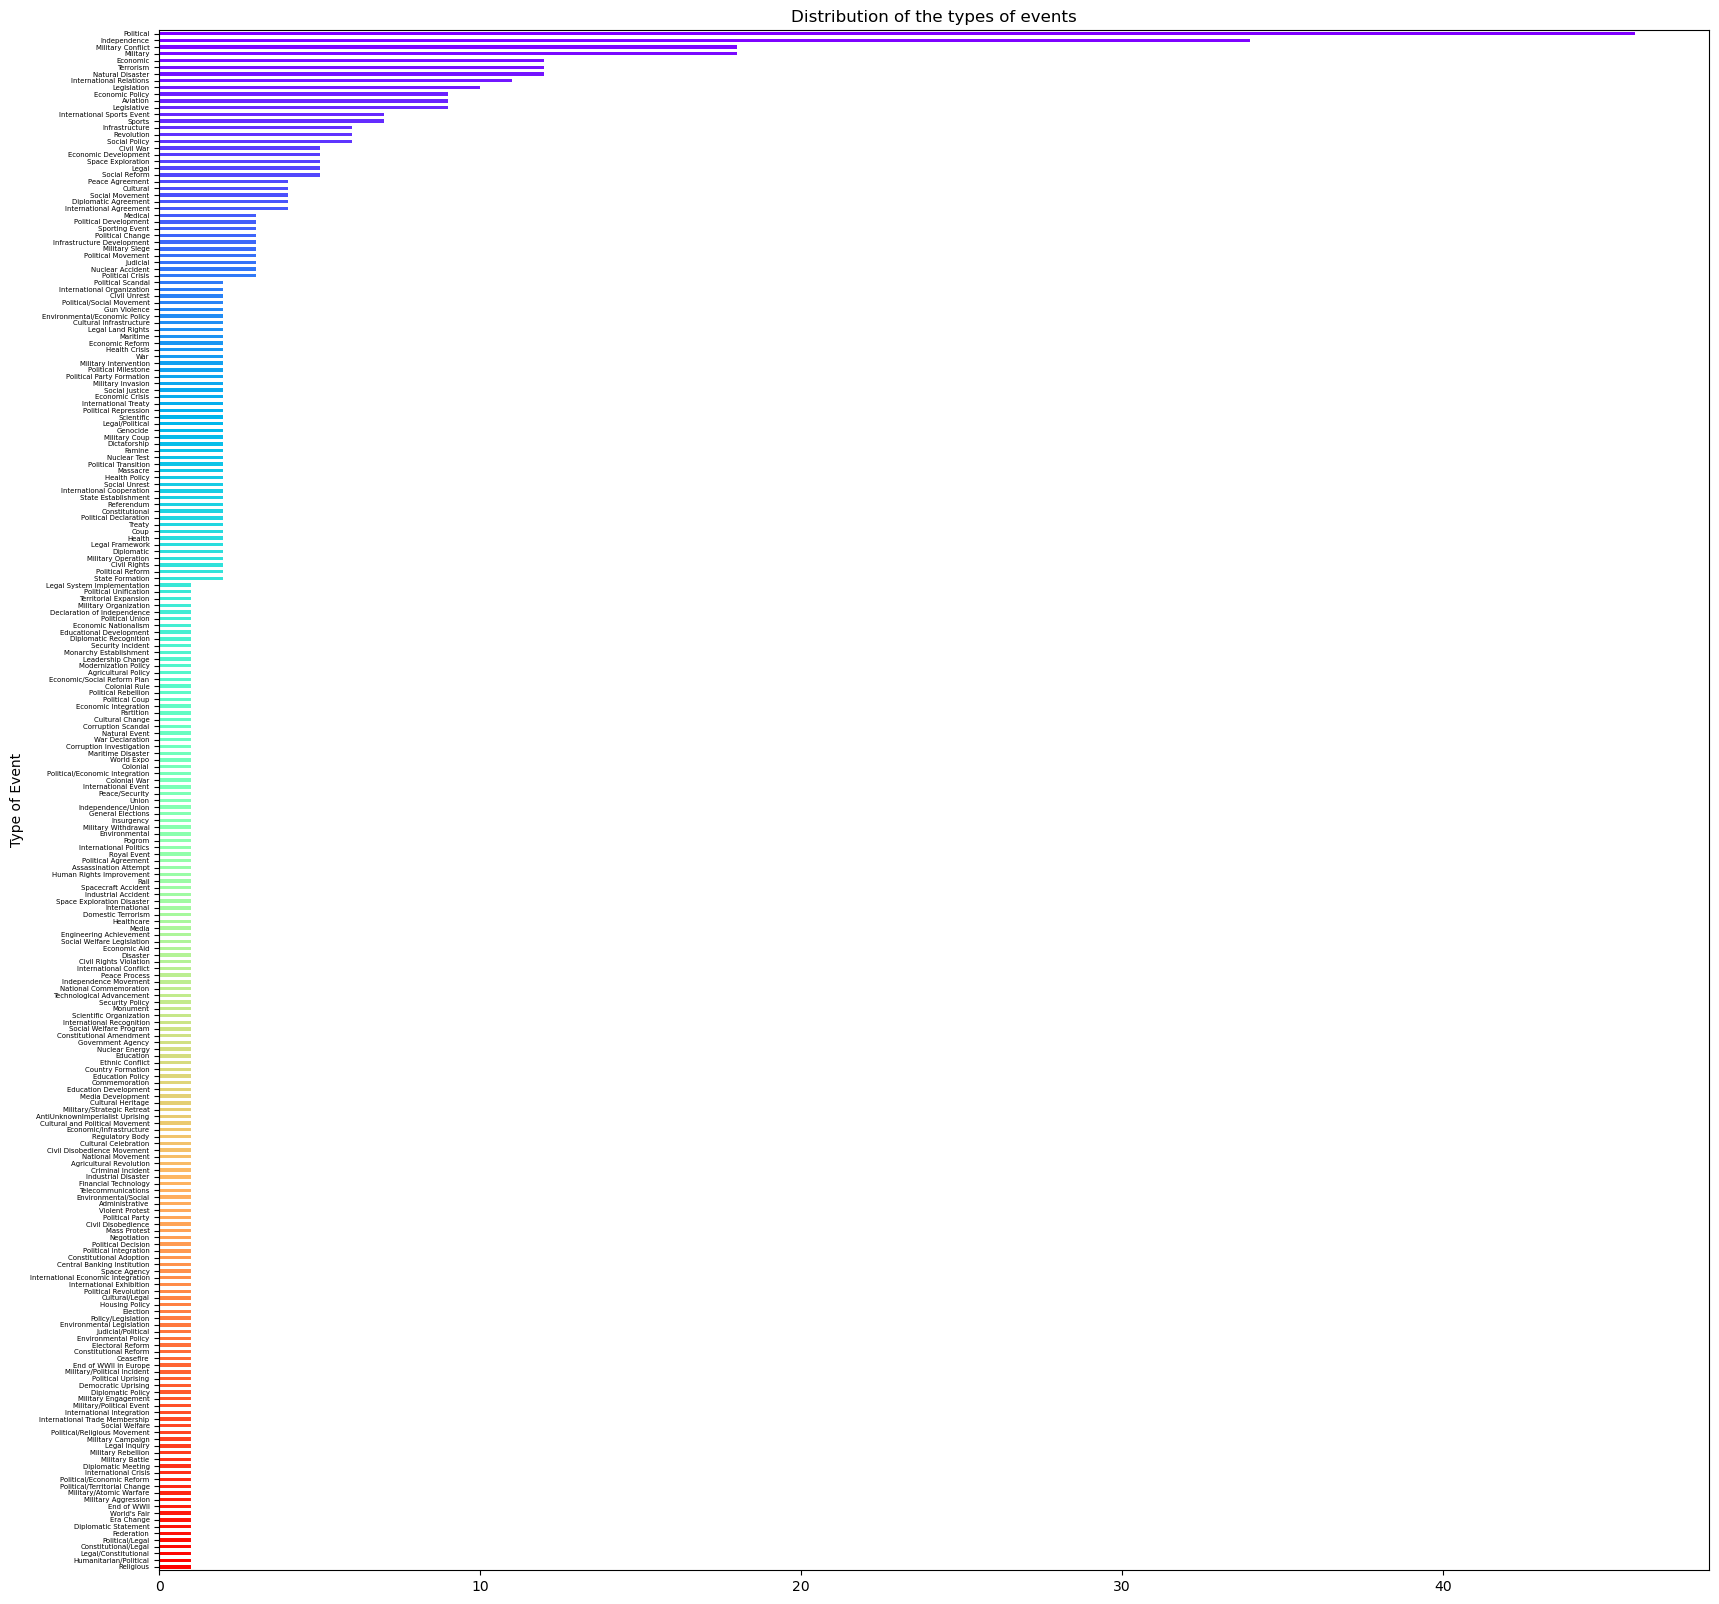

In [66]:
#Event type distribution

# For the bar colors
num_bars = len(e_types_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
e_types_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=5) 
plt.gca().invert_yaxis() 



By quick visual analysis, we see that a large number of our types of events only have one occurence.

In [67]:
t_events = e_types_counts[e_types_counts <= 10]
rare_t_events = len(t_events)

print(f"Number of event types assigned to 10 dates or less  : {rare_t_events}")

Number of event types assigned to 10 dates or less  : 221


One way to select a subset of dates: by their number of assigned dates. This is however debatably relevant because some types of events could be rare but give a much better descriptive indication of the nature of the event. For example, the top represented types of events are "Political" and "Independence" which are guite vague in nature. Moreover, we see that "Military" and "Military Conflict" have a close number of occurences. This could mean that they have a strong association: we could therefore try to aggregate the event types that are always associated together. 

Lets analyse the correlation between types of events:

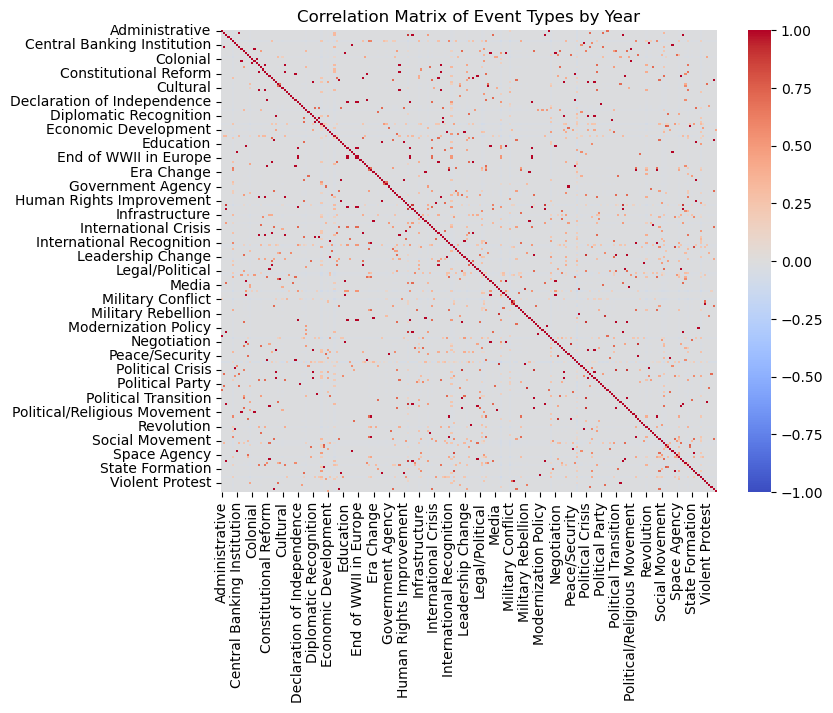

In [68]:
event_type_binary = pd.get_dummies(preprocessed_history['Type of Event'])
df_encoded = pd.concat([preprocessed_history[['Year']], event_type_binary], axis=1)
df_encoded
event_counts_by_year = df_encoded.groupby('Year').sum()
correlation_matrix = event_counts_by_year.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Correlation Matrix of Event Types by Year')
plt.show()

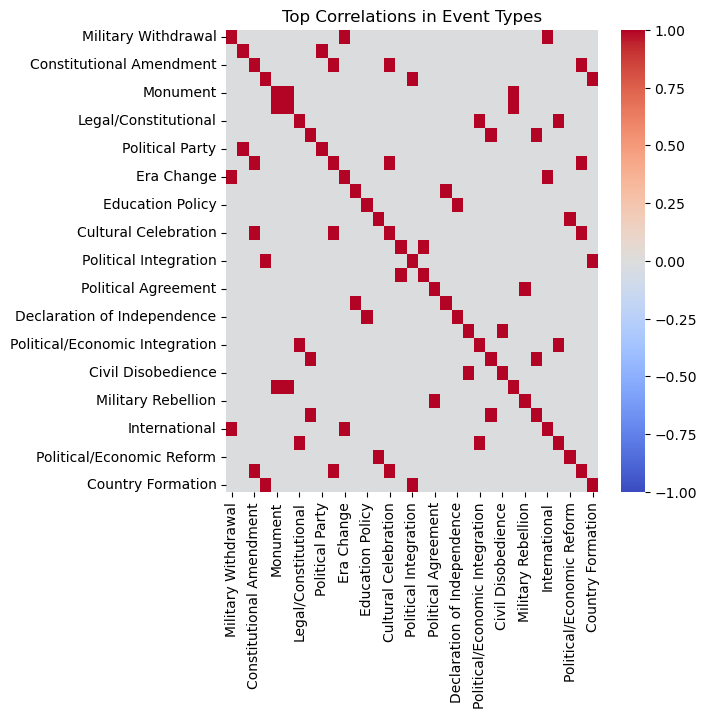

In [69]:
corr_values = correlation_matrix.unstack().reset_index()
corr_values.columns = ['Event Type 1', 'Event Type 2', 'Correlation']

corr_values = corr_values[corr_values['Event Type 1'] != corr_values['Event Type 2']]
corr_values = corr_values.reindex(corr_values['Correlation'].abs().sort_values(ascending=False).index)

top_n = 20 # top N highest correlations
top_corrs = corr_values.head(top_n)
top_event_types = list(set(top_corrs['Event Type 1']).union(set(top_corrs['Event Type 2'])))
subset_matrix = correlation_matrix.loc[top_event_types, top_event_types]

plt.figure(figsize=(6, 6))
sns.heatmap(subset_matrix, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Top Correlations in Event Types')
plt.show()

In [70]:
corr_values

,Event Type 1,Event Type 2,Correlation
8419,Democratic Uprising,Political Party,1.000000
31138,Military Engagement,Union,1.000000
6723,Cultural Celebration,Healthcare,1.000000
9643,Diplomatic Recognition,Country Formation,1.000000
43296,Political/Religious Movement,Colonial Rule,1.000000
...,...,...,...
24394,International Relations,Legislation,0.004795
27644,Legislation,Political,0.002523
37676,Political,Legislation,0.002523
24589,International Sports Event,Independence,-0.000797


# A FAIRE!

Bon tout compte fait c'est pas hyper pertinent ce que j'ai fait la donc a voir si on garde mais je pense laisser tomber. En gros j'essayer de voir si je pouvais grouper les types d'events sous le plus grand mais ca a l'air un peu bourbier.

For the time being, in order to study a manageble subset of the data, we can concentrate on a arbitrary type of event?

### > Event Country

We look at the geographical distribution of events.

In [71]:
country_counts = preprocessed_history['Country'].value_counts()
country_counts

Country
India                       44
Australia                   34
Russia                      31
United States of America    30
Pakistan                    30
                            ..
Madagascar                   1
Tanzania                     1
Ghana                        1
Côte d'Ivoire                1
Mexico                       1
Name: count, Length: 75, dtype: int64

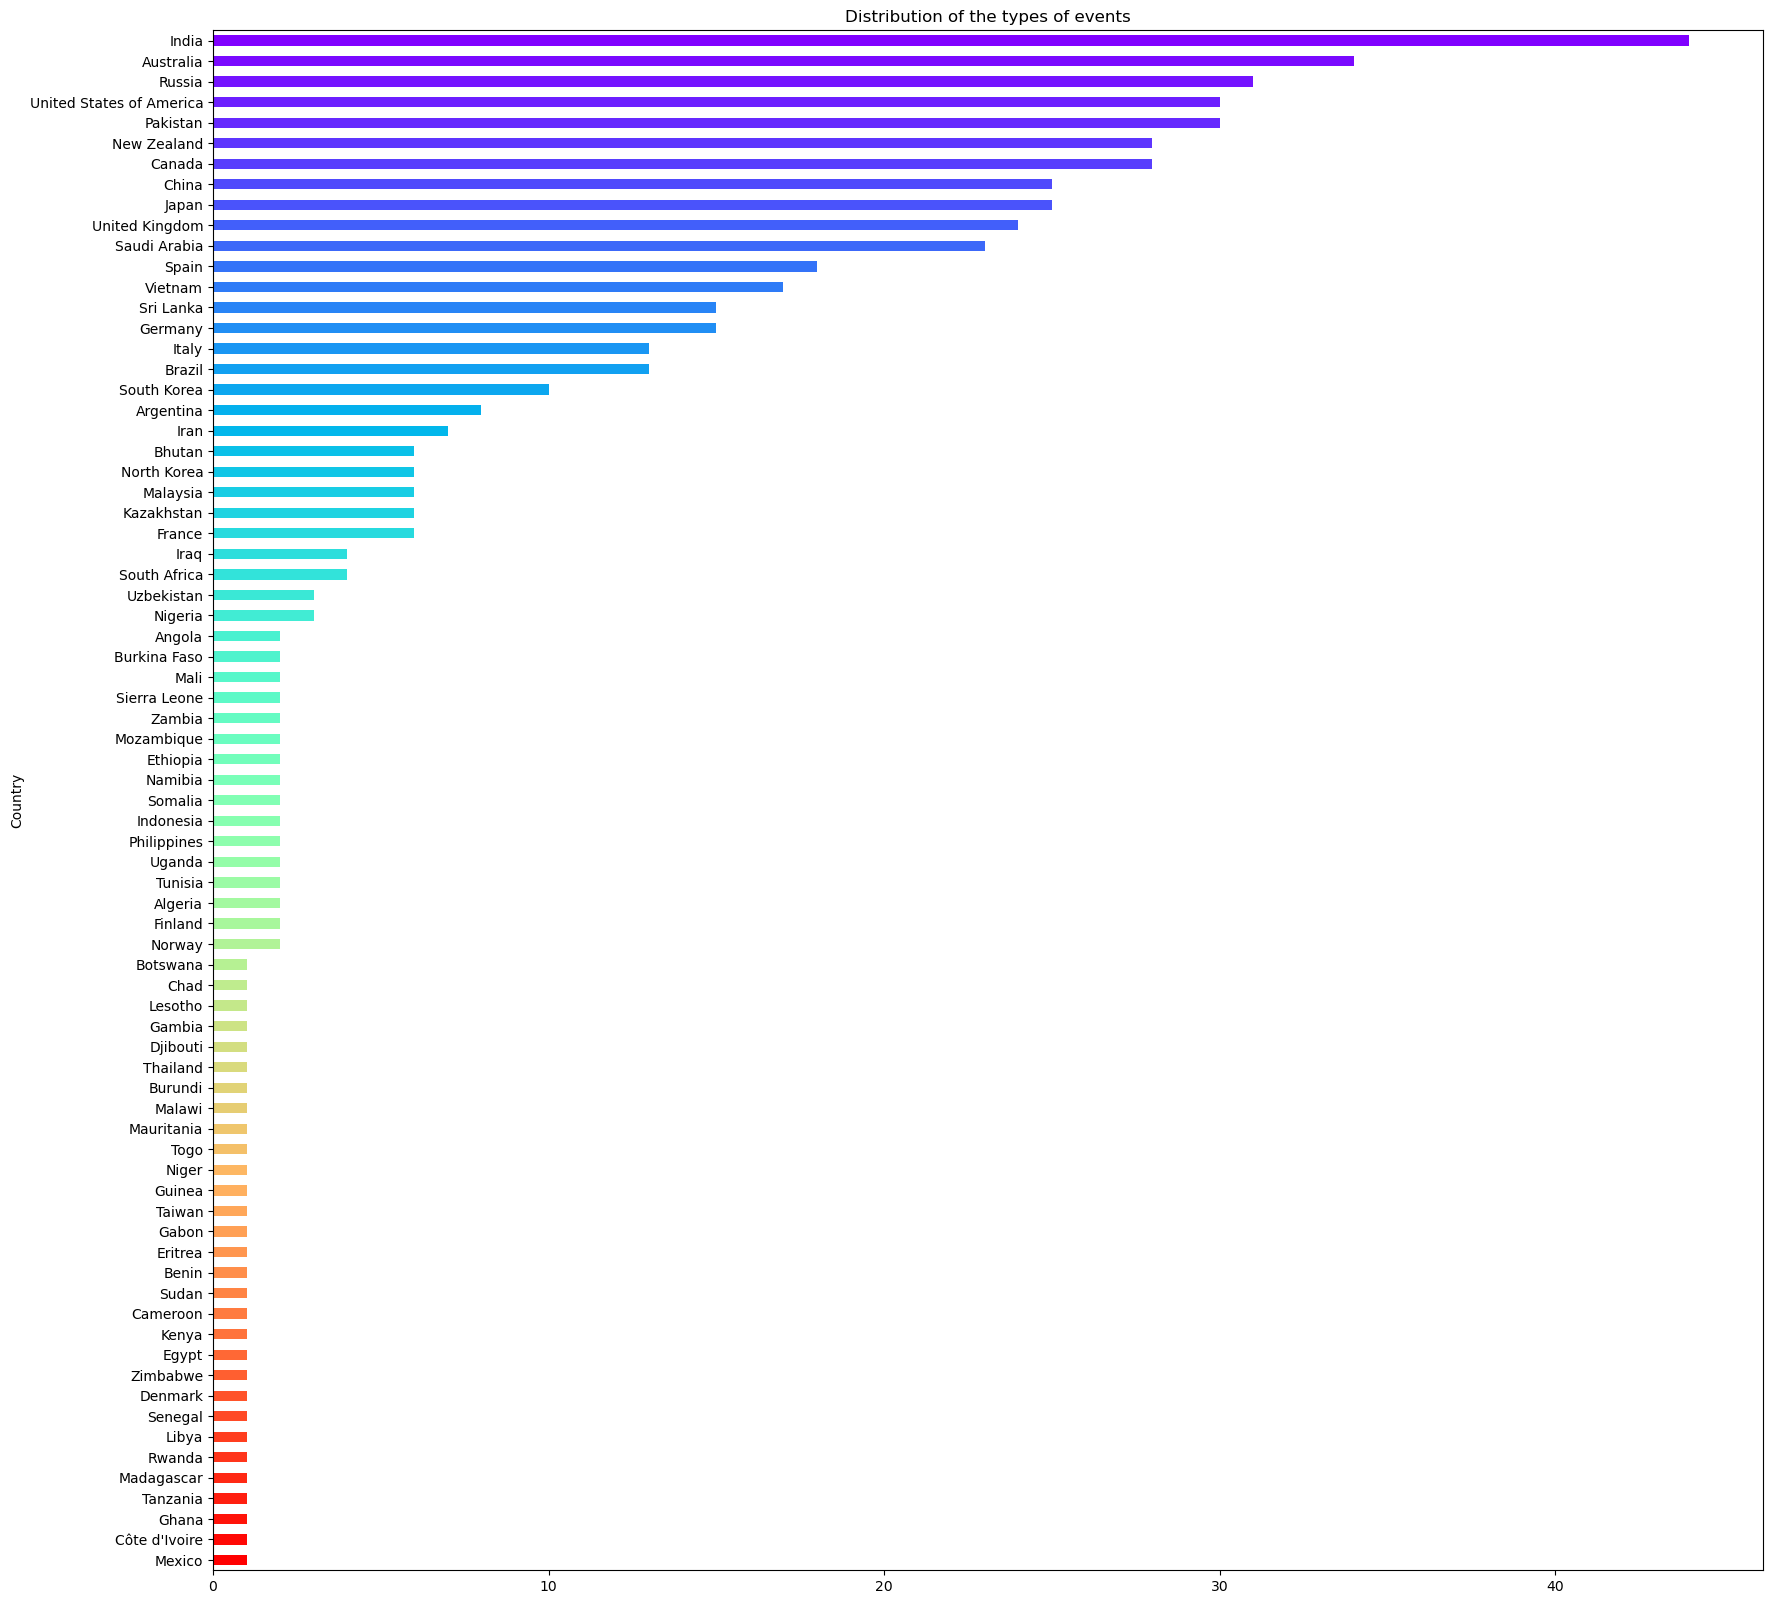

In [72]:
#Country event distribution
# For the bar colors
num_bars = len(country_counts)
colors = plt.cm.rainbow(np.linspace(0, 1, num_bars))

# Plot with rainbow colors assigned to each bar
plt.figure(figsize=(20, 20))
country_counts.plot(kind='barh', color=colors)
plt.title('Distribution of the types of events')
plt.yticks(fontsize=10) 
plt.gca().invert_yaxis() 

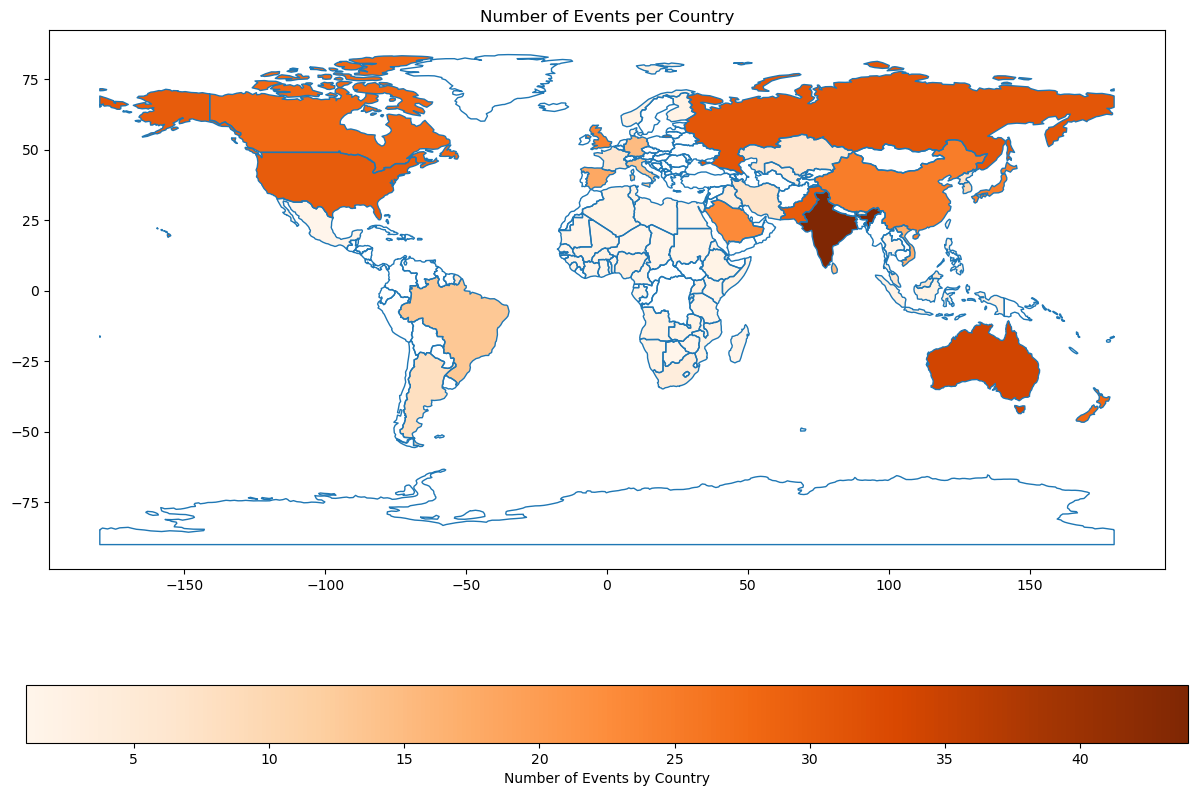

In [73]:
shapefile_path = 'data/geopandas/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)
world = world.rename(columns={'NAME': 'Country'})  # Adjust if necessary depending on the shapefile 

# aggregate the number of events per country
event_counts = preprocessed_history['Country'].value_counts()
event_counts = event_counts.reset_index()  # Convert to DataFrame for easier merging
event_counts.columns = ['Country', 'Event_Count']  # Rename columns for clarity


# merge the event counts with the world map by using 'Country' as the key for both DataFrames
merged = world.merge(event_counts, on='Country', how='left')

# plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot country boundaries
world.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Event_Count', ax=ax, legend=True,
            legend_kwds={'label': "Number of Events by Country",
                         'orientation': "horizontal"},
            cmap='Oranges')

plt.title("Number of Events per Country")
plt.show()

## 4 - Bivariate Analysis

 ### Case Study: India

Here we aim to look at correlations and influences between the variables of the data, concentrating on the events that happen in one country: India.
This can give us an idea of trends in our variables and could be useful when combined with our movie data to begin assessing the questions posed by our analysis.

In [74]:
India_events = preprocessed_history[preprocessed_history['Country']=='India']
India_movies = preprocessed_movies[preprocessed_movies['Countries']=='India']

## Distribution of movies and historical events in india from 1888 to 2018

1888 2018


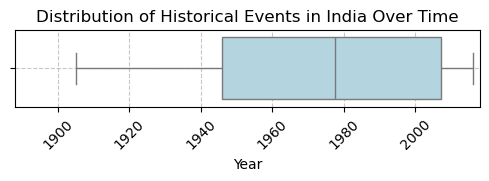

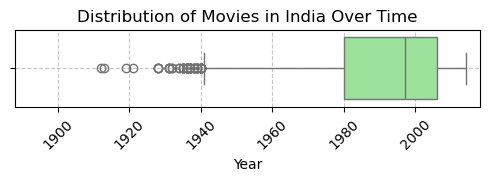

In [75]:
min_year = preprocessed_movies['Year'].min()
max_year = preprocessed_movies['Year'].max()+2  # Add 2 years for better visualization as there is an event the last year

print(min_year, max_year)

plt.figure(figsize=(6, 1))
sns.boxplot(x=India_events['Year'].astype(int), color='lightblue',)
plt.title('Distribution of Historical Events in India Over Time')
plt.xlim(min_year, max_year)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(6, 1))
sns.boxplot(x=India_movies['Year'].astype(int), color='lightgreen')
plt.title('Distribution of Movies in India Over Time')
plt.xlim(min_year, max_year)
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Map of the historical event

Here is the timeline of the events that occurs in india between __ and __. 
You can navigate through the timeline using the display bar on the right corner. 
If you scrowl on the point you can have more information on the event.
The color of the dot indicate if the outcome was classified positive or negative.

In [76]:
events = India_events.sort_values(by='Year').reset_index(drop=True)

#y_positions = [i for i in range(len(events))]   #don't know which position is the best, better looking
y_positions = np.random.uniform(len(events)*0.1, len(events)*0.8, len(events))

color_map = {'Positive': 'green', 'Negative': 'red'}
colors = events['Outcome'].map(color_map)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=events['Year'],
    y=y_positions,
    mode="markers+text",
    marker=dict(size=10, color=colors),
    text=events['Name of Incident'],
    textposition="top center",
    showlegend=False,  
    hovertext=events.apply(lambda row: f"Event: {row['Name of Incident']}<br>Type of event: {row['Type of Event']}<br>Affected Population: {row['Affected Population']}", axis=1),
    hoverinfo="text"
))

fig.update_layout(
    title="Timeline of Historical Events in India since 1900",
    xaxis=dict(range=[1880, 2025], title="Year"),  # We take range value out of the range of event for clarity of the plot
    yaxis=dict(range=[0, len(events) ], visible=False),    #just for positionning, doesn't make sense to show it
    width=1200,  
    height=500
)

fig.show(config={'displayModeBar': True})


If the project is visualized online, this Plotly plot will not appear because it is an interactive plot. Thus, here is a picture of the timeline of historical events in India since 1900.

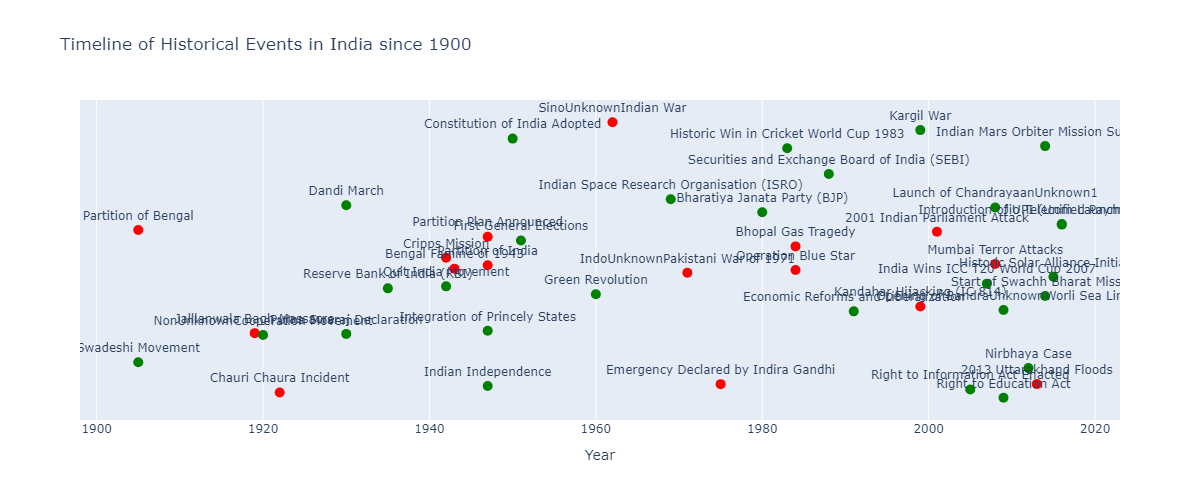

In [77]:
Image(filename='src/india_plot_1.png')

There are many events to consider, so we'll focus on selecting the most significant ones. However, since the criteria for importance aren't defined, let's take a moment to think it through.

Considering the "Affected Population" as a criterion sounds reasonable. 
Let's focus on selecting events that impact the entire Indian population. 
This approach can help us narrow down the most significant events affecting the whole nation.

In [78]:
list_affected = India_events["Affected Population"].tolist()
list_affected [:6]

['Hindus, Muslims, Sikhs',
 'Bengalis in East Pakistan',
 'Citizens of Mumbai',
 'Indian nationalists',
 'Indian farmers',
 'Sikh community']

We have multiple labels describing the same population. For example, terms like "Indian citizens," "Indian civilians,"People of India " "Indian population ", "All citizens of India" all refer to the same group.

In [79]:
indian_commu_affected = India_events[India_events["Affected Population"].str.contains("Indian citizens|Indian civilianPeople of India|Indian population|All citizens of Indias", case=False, na=False)]

len(indian_commu_affected)

7

In [80]:
events = indian_commu_affected.sort_values(by='Year').reset_index(drop=True)

y_positions = [i for i in range(len(events))]   #don't know which position is the best, better looking
#y_positions = np.random.uniform(len(events)*0.1, len(events)*0.8, len(events))

color_map = {'Positive': 'green', 'Negative': 'red'}
colors = events['Outcome'].map(color_map)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=events['Year'],
    y=y_positions,
    mode="markers+text",
    marker=dict(size=10, color=colors),
    text=events['Name of Incident'],
    textposition="top center",
    showlegend=False,  
    hovertext=events.apply(lambda row: f"Event: {row['Name of Incident']}<br>Type of event: {row['Type of Event']}<br>Affected Population: {row['Affected Population']}", axis=1),
    hoverinfo="text"
))

fig.update_layout(
    title="Timeline of Historical Events in India since 1900",
    xaxis=dict(range=[1880, 2025], title="Year"),  # We take range value out of the range of event for clarity of the plot
    yaxis=dict(range=[0, len(events) ], visible=False),    #just for positionning, doesn't make sense to show it
    width=1200,  
    height=500
)
fig.show(config={'displayModeBar': True})

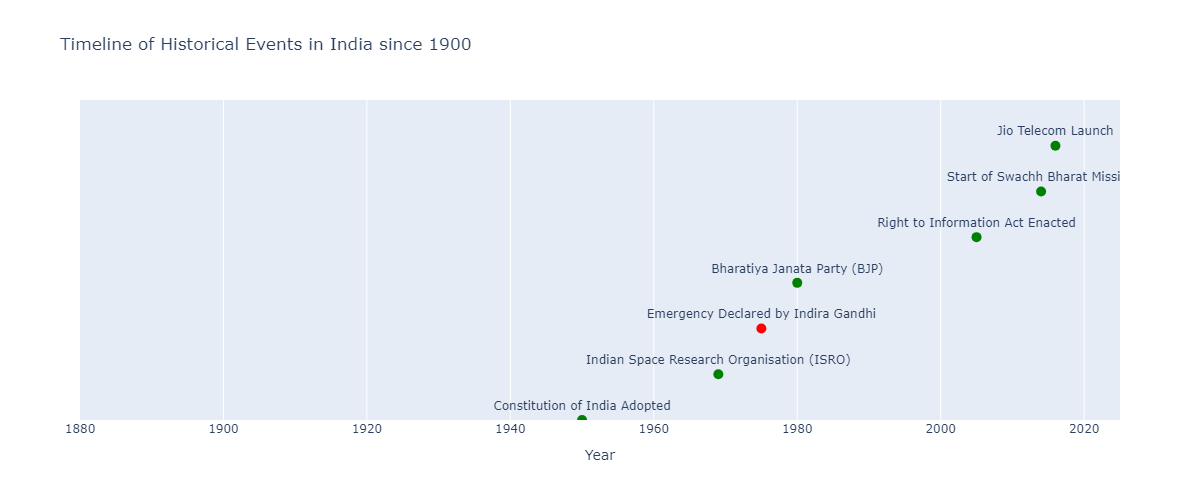

In [81]:
Image(filename='src/india_plot_2.png')

## 5 -  Conclusion and Future Perspectives (ecrit un peu grace a chat donc a rectifier si besoin)

To continue this project and further push our analysis, it could be interesting to pose some hypotheses on the distribution of our variables and how they influence one another. For example, we could imagine that the rise in wars in a given country could lead to an increase in movie releases with war-related genres. It could therefore be interesting to assess the statistical significance of historical events as confounding factors for trends in movie releases.

One approach could be to analyze correlations between historical event frequencies (e.g., wars, economic crises) and the prevalence of certain movie genres over time. This would involve computing correlation coefficients or using regression models to quantify the strength of these relationships. For instance, we could test whether an increase in war-related events correlates with an increase in war-themed movies, controlling for other variables such as economic conditions and popular culture trends.

Additionally, hypothesis testing can help verify whether observed trends are statistically significant or likely due to random variation. For example, we could set up a hypothesis test to see if the proportion of war-related movies significantly increases following war periods compared to stable periods.

Finally, to enhance interpretability, clustering techniques might help categorize similar trends and patterns within the dataset, allowing us to identify genres that respond similarly to specific types of historical events. This could reveal latent relationships within our data that might be overlooked in simple pairwise analyses.

These methods would give us a more robust understanding of how external events might act as drivers or influencers of movie genre trends, allowing us to make informed conclusions about the cultural impact of historical contexts on film production.

## COMMENT dans le dataset on comprend si un evenement a été vraiment important ou non??

La prochaine étape est de faire des plots, voici mes idées mais rajoutez en à votre guise!! 

- Proportion de chaque genre dans les films sortis chaque année. (lineplot?)  (update Fait dan genre analysis)
- Heatmap temporelle avec les années et les genres pourrait aussi aider à voir les pics et baisses de popularité des genres.
- Comparer les genres populaires à des périodes historiques précises (avant, pendant, après).
- Ligne temporelle des revenus du box office pour des genres particuliers, avec des annotations pour les films les plus réussis. Les pics ou succès importants peuvent être marqués pour voir si d'autres films de genre similaire ont suivi. (matplotib.pyplot)
- Montrez la durée pendant laquelle un genre reste populaire après le succès d’un film spécifique. Chaque barre représente un genre et montre la période pendant laquelle il est resté en tendance. (barplot?)
- Carte géographique et graphique pour montrer l’origine des films (par pays) et un graphique en barres empilées pour voir comment les genres évoluent dans les différentes régions, en mettant en avant la diffusion de genres américains. (plotly.express.choropleth et seaborn)


Autres idées de chose à regarder par rapport au nouveau dataset: 
- si le nombre de negative outcome historique ont une correlation avec le nombre de comedies or tragedies dans les genre types?